# Time Series - Clustering
Data Understanding and Preparation
- Explore and prepare the time series dataset.
- Preprocess the dataset in order to be able to run time series
clustering; motif/anomaly discovery and classification. If the dataset is
too big for these tasks, you can use approximations (e.g. SAX, PAA etc)

Motifs/Discords
- Analyze the dataset for finding motifs and/or anomalies. Visualize and
discuss them and their relationship with shapelets.

Clustering
- Use at least two clustering algorithm on time series using an
appropriate distance.
- Analyze the clusters and highlight similarities and differences and
visualize the clusters using at least 2 dimensionality reduction
techniques.

Classification
Define one (or more) classification task and solve it using:
- KNN with at least two distances
    - Euclidean/Manhattan
    - DTW
    - Shapelets
    - Analyze the shapelets retrieved
- At least one other method (rocket, muse, cnn, rnn etc)

In [35]:
# Importing libraries
import pandas as pd
import numpy as np

from collections import Counter
from collections import defaultdict

from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectFromModel, RFE
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
                            
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from imblearn.over_sampling import ADASYN

from sklearn.utils import shuffle
import random

from IPython.display import Audio 
import pathlib
from tqdm.notebook import tqdm
import librosa
import awkward as ak

# Data visualization
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
plt.style.use("ggplot")
rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 50)

### TS libraries

In [36]:
#Time Series Preprocessing
from tslearn.preprocessing import TimeSeriesScalerMinMax
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

#Distances
from scipy.spatial.distance import euclidean, cityblock
from tslearn.metrics import dtw, dtw_path, cdist_dtw, subsequence_cost_matrix

#Time Series Approximation
from scipy.signal import decimate
from pyts.approximation import DiscreteFourierTransform, SymbolicAggregateApproximation
from sklearn.decomposition import TruncatedSVD, randomized_svd
from tslearn.piecewise import PiecewiseAggregateApproximation
from tslearn.piecewise import SymbolicAggregateApproximation

#Time Series Clustering
from tslearn.clustering import TimeSeriesKMeans
from matplotlib.pyplot import cm
#scaling, normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#kmeans, dbscan, hierarchical (sklearn)
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
#evaluation
from sklearn.metrics import silhouette_score,rand_score, adjusted_rand_score, mutual_info_score,\
                                adjusted_mutual_info_score, v_measure_score, fowlkes_mallows_score

from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from dtaidistance import dtw

#import dataset
from sklearn.datasets import load_iris

#distance matrix (dbscan elbow, hierarchical)
from scipy.spatial.distance import pdist, squareform
# hierarchical (scipy)
from scipy.cluster.hierarchy import linkage, dendrogram

In [37]:
def imp_data(data_filename, data_npy, emotions = 8):
    # default emotions = 8, else change emotions to 3 (only 3 supported)
    
    df_all = pd.concat([pd.read_csv(data_filename)['emotion'], pd.DataFrame(np.load(data_npy))], axis = 1)
    #df_all = pd.read_csv(data_filename)
    df_all.head()

    # TRAIN and TEST datasets split (and labels)
    targ = 'emotion'
    labels = df_all.pop(targ)
    df_train, df_test = df_all.loc[:1827,:], df_all.loc[1828:,:]

    # Label Encoder
    le = LabelEncoder()
    labels = le.fit_transform(labels)
    label_encoder_name_mapping = dict(zip(le.classes_,
                                             le.transform(le.classes_)))
    #print("Mapping of Label Encoded Classes: ", label_encoder_name_mapping, sep="\n")

    # splitting the labels in train and test
    labels_train, labels_test = labels[:1828], labels[1828:]
    df_train.insert(0,str(targ),labels_train)
    df_test.insert(0,str(targ),labels_test)

    frac = 0.2
    df_train_s = df_train.groupby(targ).sample(frac = frac, random_state=42)

    # new sampled training data
    df_train = df_train_s.copy(deep=True)

    # vars to encode
    #cat_vars = ['emotion']

    # one hot encoding of train df_train and df_test
    #df_train = pd.get_dummies(df_train, columns = cat_vars, prefix = '', prefix_sep='')
    #df_test = pd.get_dummies(df_test, columns = cat_vars, prefix = '', prefix_sep='')

    # converting df_train and df_test into np matrices and arrays
    X, X_test = df_train.iloc[:,1:].values, df_test.iloc[:,:1:].values
    y, y_test = df_train.loc[:,targ].values, df_test.loc[:,targ].values

    # shuffling train and val concatenation to remove potential pattern bias
    X, y  = shuffle(X, y, random_state=42)

    # scaling the time series
    scl_mv = TimeSeriesScalerMinMax()
    X = scl_mv.fit_transform(X)
    X = np.squeeze(X)

    # selection of only a part (a segment) of the time series for the clustering task
    X_clust = X.copy()
    y_clust = y.copy().astype(np.int8)

    df_clust = pd.concat([pd.DataFrame(y_clust.astype(np.int8).T, columns = [targ]), pd.DataFrame(X_clust)], axis=1)

    # if we want to reduce the classes from 8 to 3 for ex. grouping emotions based on knowledge about the domain
    #if emotions == 3:
    #    high = [0,3,7]
    #    medium = [2,5,6]
    #    low = [1,4]
    #    replacement = {1:0,4:0,2:1,5:1,6:1,0:2,3:2,7:2}
    #    df_clust = df_clust.replace({targ:replacement})
    #    y_clust = df_clust.loc[:,targ].values.astype(np.int8)

    return X_clust, y_clust, df_clust

In [38]:
def imp_for_centroids(data_filename, fraction = 0.25, emotions = 8):
    # default emotions = 8, else change emotions to 3 (only 3 supported)
    df_all = pd.read_csv(data_filename)
    df_all.head()

    # TRAIN and TEST datasets split (and labels)
    targ = 'emotion'
    labels = df_all.pop(targ)
    df_train, df_test = df_all.loc[:1827,:], df_all.loc[1828:,:]
    print(labels.unique())
    # Label Encoder
    le = LabelEncoder()
    labels = le.fit_transform(labels)
    label_encoder_name_mapping = dict(zip(le.classes_,
                                             le.transform(le.classes_)))
    #print("Mapping of Label Encoded Classes: ", label_encoder_name_mapping, sep="\n")

    # splitting the labels in train and test
    labels_train, labels_test = labels[:1828], labels[1828:]
    df_train.insert(0,str(targ),labels_train)
    df_test.insert(0,str(targ),labels_test)

    frac = fraction
    df_train_s = df_train.groupby(targ).sample(frac = fraction, random_state=42)

    # new sampled training data
    df_train = df_train_s.copy(deep=True)

    # vars to encode
    #cat_vars = ['emotion']

    # one hot encoding of train df_train and df_test
    #df_train = pd.get_dummies(df_train, columns = cat_vars, prefix = '', prefix_sep='')
    #df_test = pd.get_dummies(df_test, columns = cat_vars, prefix = '', prefix_sep='')

    # converting df_train and df_test into np matrices and arrays
    X, X_test = df_train.iloc[:,1:].values, df_test.iloc[:,:1:].values
    y, y_test = df_train.loc[:,targ].values, df_test.loc[:,targ].values

    # shuffling train and val concatenation to remove potential pattern bias
    X, y  = shuffle(X, y, random_state=42)

    # scaling the time series
    #scl_mv = TimeSeriesScalerMinMax(mu=0., std=1.)
    #X = scl_mv.fit_transform(X)
    #X = np.squeeze(X)

    # selection of only a part (a segment) of the time series for the clustering task
    X_clust = X.copy()
    y_clust = y.copy().astype(np.int8)

    df_clust = pd.concat([pd.DataFrame(y_clust.astype(np.int8).T, columns = [targ]), pd.DataFrame(X_clust)], axis=1)

    # if we want to reduce the classes from 8 to 3 for ex. grouping emotions based on knowledge about the domain
    #if emotions == 3:
    #    high = [0,3,7]
    #    medium = [2,5,6]
    #    low = [1,4]
    #    replacement = {1:0,4:0,2:1,5:1,6:1,0:2,3:2,7:2}
    #    df_clust = df_clust.replace({targ:replacement})
    #    y_clust = df_clust.loc[:,targ].values.astype(np.int8)

    return X_clust, y_clust, df_clust

In [39]:
def plot_eval_clust(km_labels, y_clust, X_clust):
    if len(np.unique(km_labels)) == 3:
        emotions = ['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']#['quiet','normal','loud']
    else:
        emotions = ['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

    tab = pd.crosstab(km_labels,y_clust)
    tab = tab.div(tab.sum(1).astype(float), axis=0)
    tab.plot(kind='bar', stacked=True,color=['darkred','blue','pink','crimson','orange','royalblue','skyblue','goldenrod'], width = 0.8, figsize = (8,5))

    plt.xlabel('Cluster', fontsize = 15)
    plt.xticks(rotation=0, fontsize = 15)
    plt.yticks(rotation=0, fontsize = 15)
    plt.ylabel('Emotion (%)', fontsize = 15)
    #rotate x labels 90 degrees

    plt.legend(emotions,loc='upper left',bbox_to_anchor=(1, 1), fontsize = 15)
    plt.show()

    print()
    print()

    amis = adjusted_mutual_info_score(y_clust, km_labels)
    ars = adjusted_rand_score(y_clust, km_labels)
    fms = fowlkes_mallows_score(y_clust, km_labels)
    ss = silhouette_score(X_clust, km_labels)
    score_names = ['adjusted_mutual_info_score ', 'adjusted_rand_score', 'fowlkes_mallows_score', 'silhouette_score'] # good 1, bad usually 0 or negative
    scores_km = [amis, ars, fms, ss]
    for i in range(len(scores_km)):
        print(f'{score_names[i].capitalize()} = {round(scores_km[i],3)}')

In [40]:
def dft_inverse_trasform(X_dft, n_coefs, n_timestamps):
    # Compute the inverse transformation
    n_samples = X_dft.shape[0]
    if n_coefs % 2 == 0:
        real_idx = np.arange(1, n_coefs, 2)
        imag_idx = np.arange(2, n_coefs, 2)
        X_dft_new = np.c_[
            X_dft[:, :1],
            X_dft[:, real_idx] + 1j * np.c_[X_dft[:, imag_idx],
                                            np.zeros((n_samples, ))]
        ]
    else:
        real_idx = np.arange(1, n_coefs, 2)
        imag_idx = np.arange(2, n_coefs + 1, 2)
        X_dft_new = np.c_[
            X_dft[:, :1],
            X_dft[:, real_idx] + 1j * X_dft[:, imag_idx]
        ]
    X_irfft = np.fft.irfft(X_dft_new, n_timestamps)
    return X_irfft

In [41]:
def plot_pca_clust(X_clust, km_labels, name = ''):    
    n_com = 2
    pca = PCA(n_components=n_com)
    pca.fit(X_clust)
    principalComponents = pca.transform(X_clust)
    principalDf = pd.DataFrame(data = principalComponents
                        , columns = ['pc'+str(i) for i in range(1,n_com+1)])
    
    # Kmeans centroids
    centroids = []
    for i in range(0,8):
        centroids.append(np.mean(principalDf[km_labels == i], axis = 0))
    centroids = pd.DataFrame(centroids, columns = ['pc1', 'pc2'])
    
    if len(np.unique(km_labels)) == 8:
        plt.scatter(principalDf[km_labels==0]['pc1'],principalDf[km_labels==0]['pc2'], s = 60, edgecolor = 'grey', color = 'blue')
        plt.scatter(principalDf[km_labels==1]['pc1'],principalDf[km_labels==1]['pc2'], s = 60, edgecolor = 'grey', color = 'forestgreen')
        plt.scatter(principalDf[km_labels==2]['pc1'],principalDf[km_labels==2]['pc2'], s = 60, edgecolor = 'grey', color = 'deepskyblue')
        plt.scatter(principalDf[km_labels==3]['pc1'],principalDf[km_labels==3]['pc2'], s = 60, edgecolor = 'grey', color = 'salmon')
        plt.scatter(principalDf[km_labels==4]['pc1'],principalDf[km_labels==4]['pc2'], s = 60, edgecolor = 'grey', color = 'limegreen')
        plt.scatter(principalDf[km_labels==5]['pc1'],principalDf[km_labels==5]['pc2'], s = 60, edgecolor = 'grey', color = 'goldenrod')
        plt.scatter(principalDf[km_labels==6]['pc1'],principalDf[km_labels==6]['pc2'], s = 60, edgecolor = 'grey', color = 'crimson')
        plt.scatter(principalDf[km_labels==7]['pc1'],principalDf[km_labels==7]['pc2'], s = 60, edgecolor = 'grey', color = 'cyan')

        
        edgecolor = 'k'
        plt.scatter(centroids.loc[0,'pc1'],centroids.loc[0,'pc2'], label='Centroid Cluster 1\n', linewidth = 2, edgecolor = edgecolor, marker = 'X', s=400, c='blue',      )
        plt.scatter(centroids.loc[1,'pc1'],centroids.loc[1,'pc2'], label='Centroid Cluster 2\n', linewidth = 2, edgecolor = edgecolor, marker = 'X', s=400, c='forestgreen')
        plt.scatter(centroids.loc[2,'pc1'],centroids.loc[2,'pc2'], label='Centroid Cluster 3\n', linewidth = 2, edgecolor = edgecolor, marker = 'X', s=400, c='deepskyblue')
        plt.scatter(centroids.loc[3,'pc1'],centroids.loc[3,'pc2'], label='Centroid Cluster 4\n', linewidth = 2, edgecolor = edgecolor, marker = 'X', s=400, c='salmon',    )
        plt.scatter(centroids.loc[4,'pc1'],centroids.loc[4,'pc2'], label='Centroid Cluster 5\n', linewidth = 2, edgecolor = edgecolor, marker = 'X', s=400, c='limegreen', )
        plt.scatter(centroids.loc[5,'pc1'],centroids.loc[5,'pc2'], label='Centroid Cluster 6\n', linewidth = 2, edgecolor = edgecolor, marker = 'X', s=400, c='goldenrod', )
        plt.scatter(centroids.loc[6,'pc1'],centroids.loc[6,'pc2'], label='Centroid Cluster 7\n', linewidth = 2, edgecolor = edgecolor, marker = 'X', s=400, c='crimson',   )
        plt.scatter(centroids.loc[7,'pc1'],centroids.loc[7,'pc2'], label='Centroid Cluster 8\n', linewidth = 2, edgecolor = edgecolor, marker = 'X', s=400, c='cyan',      )

        plt.title(f'{name.upper()}')
        plt.legend()
        plt.yticks(fontsize = 15)
        plt.xticks(fontsize = 15)
        plt.xlabel('Principal Component 1', fontsize = 15)
        plt.ylabel('Principal Component 2', fontsize = 15)
        plt.show()
        plt.close()
    

    else:
        plt.scatter(principalDf[km_labels==0]['pc1'],principalDf[km_labels==0]['pc2'], s = 60, edgecolor = 'grey', color = 'blue')
        plt.scatter(principalDf[km_labels==1]['pc1'],principalDf[km_labels==1]['pc2'], s = 60, edgecolor = 'grey', color = 'forestgreen')
        plt.scatter(principalDf[km_labels==2]['pc1'],principalDf[km_labels==2]['pc2'], s = 60, edgecolor = 'grey', color = 'crimson')


        # Kmeans centroids
        centroids = []
        for i in range(0,3):
            centroids.append(np.mean(principalDf[km_labels == i], axis = 0))
        centroids = pd.DataFrame(centroids, columns = ['pc1', 'pc2'])
        edgecolor = 'k'
        plt.scatter(centroids.loc[0,'pc1'],centroids.loc[0,'pc2'], label='Centroid Cluster 1\n', linewidth = 2, edgecolor = edgecolor, marker = 'X', s=400, c='blue',      )
        plt.scatter(centroids.loc[1,'pc1'],centroids.loc[1,'pc2'], label='Centroid Cluster 2\n', linewidth = 2, edgecolor = edgecolor, marker = 'X', s=400, c='forestgreen')
        plt.scatter(centroids.loc[2,'pc1'],centroids.loc[2,'pc2'], label='Centroid Cluster 3\n', linewidth = 2, edgecolor = edgecolor, marker = 'X', s=400, c='crimson')

        plt.title(f'{name.upper()}')
        plt.legend()
        plt.yticks(fontsize = 15)
        plt.xticks(fontsize = 15)
        plt.xlabel('Principal Component 1', fontsize = 15)
        plt.ylabel('Principal Component 2', fontsize = 15)
        plt.show()
        plt.close()

In [42]:
def dtw_and_matrix(X_clust):
    X_clust = np.squeeze(X_clust)
    distance_matrix = []
    m = len(X_clust)    
    for i in range(0, m - 1):
        for j in range(i + 1, m):
            distance_matrix.append(dtw.distance_fast(X_clust[i].astype('double'), X_clust[j].astype('double')))
    
    distance_matrix = np.array(distance_matrix)
    d_mat = squareform(distance_matrix)

    return distance_matrix, d_mat
    

In [43]:
def plot_dendr(d, name = '', method = 'complete', color_threshold = 0):
    
    data_link = linkage(d, method = method)
    res = dendrogram(data_link, truncate_mode = 'lastp', color_threshold = color_threshold, above_threshold_color='k')
    plt.title(f'{method.capitalize()} Linkage {name.upper()}')
    #calculate Cophenetic Correlation Coefficient
    c, coph_dists = cophenet(data_link, d)
    print(f'Cophenetic Coefficient: {c}')

In [44]:
np.random.seed(42)  # for reproducibility

In [45]:
import joblib

In [46]:
fraction = 0.2
n_clusters = 8

In [47]:
X_centr, y_centr, df_centr = imp_for_centroids('data_ts\data_dec_scld.csv', fraction = fraction, emotions = n_clusters)
Xdf_centr, ydf_centr = df_centr.iloc[:,1:], df_centr.iloc[:,0]
print(X_centr.shape, y_centr.shape)
print(Xdf_centr.shape, ydf_centr.shape)

df_centr.head()

['fearful' 'disgust' 'neutral' 'happy' 'calm' 'surprised' 'sad' 'angry']
(366, 3000) (366,)
(366, 3000) (366,)


,emotion,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,...,2900,2901,2902,2903,2904,2905,2906,2907,2908,2909,2910,2911,2912,2913,2914,2915,2916,2917,2918,2919,2920,2921,2922,2923,2924,2925,2926,2927,2928,2929,2930,2931,2932,2933,2934,2935,2936,2937,2938,2939,2940,2941,2942,2943,2944,2945,2946,2947,2948,2949,2950,2951,2952,2953,2954,2955,2956,2957,2958,2959,2960,2961,2962,2963,2964,2965,2966,2967,2968,2969,2970,2971,2972,2973,2974,2975,2976,2977,2978,2979,2980,2981,2982,2983,2984,2985,2986,2987,2988,2989,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
0,3,0.053089,-0.032862,0.024607,-0.015404,-0.101163,0.064593,-0.001025,0.066360,0.091200,-0.077449,0.054618,-0.037371,-0.081749,0.019922,-0.013117,0.026027,0.020913,0.056697,-0.139390,-0.099169,0.087688,0.105028,0.284684,-0.100427,0.038835,-0.751446,-0.670507,1.256607,0.393322,0.534788,-0.591166,-1.905436,0.748771,0.686192,0.348554,0.589916,0.080985,-1.262934,-1.456496,1.095604,0.928102,0.323666,0.594571,-0.809248,-1.894475,0.228025,1.402733,0.432078,0.716536,-0.791504,-1.989240,0.217213,1.140047,0.573860,0.598413,-0.233827,-1.759500,-0.571482,1.130160,0.719560,0.796177,-0.255059,-1.881244,-0.358118,0.840578,0.691819,1.009061,-0.429927,-1.847673,-0.212428,0.886662,0.611637,0.938294,-0.352288,-1.730439,-0.491996,0.702574,0.861927,1.034171,-0.104871,-1.953356,-0.705426,0.909710,0.732205,1.041082,-0.008643,-1.773529,-0.738245,0.582804,0.714225,1.029784,0.101340,-1.407056,-0.813339,0.296805,0.622757,1.046952,0.232090,-1.297789,...,-0.290573,0.058693,0.386201,0.280671,-0.128657,-0.440344,-0.304100,0.173746,0.477526,0.297397,-0.228352,-0.537989,-0.238935,0.312166,0.486853,0.212302,-0.297139,-0.528027,-0.106324,0.315502,0.367440,0.132736,-0.317562,-0.354163,0.018680,0.230443,0.243355,-0.024758,-0.274083,-0.102511,0.113629,0.157863,0.063315,-0.121096,-0.153185,0.034127,0.153109,0.041800,-0.067969,-0.114439,0.010854,0.138478,-0.052741,-0.064443,0.060331,0.000922,0.004435,-0.048679,-0.011854,0.121524,-0.005138,-0.135464,-0.038328,0.141051,0.115968,-0.059176,-0.147104,-0.069462,0.152759,0.118620,-0.092016,-0.123930,-0.033493,0.115507,0.101762,-0.064833,-0.103894,-0.008772,0.088585,0.072070,-0.069536,-0.090803,0.065217,0.081671,-0.056188,-0.067127,0.045464,0.055835,-0.032535,-0.043521,0.026670,0.019534,0.008420,0.024240,-0.045691,-0.000348,0.061081,-0.039343,-0.031359,0.065203,0.018481,-0.062780,0.022315,0.050581,-0.050820,0.005783,0.044985,-0.003515,0.025598,0.026129
1,0,0.004251,0.000212,0.002298,0.002055,-0.001524,-0.001179,0.002953,-0.002744,0.002639,0.005505,-0.011955,-0.001212,0.012329,-0.008041,-0.012153,0.011467,0.008081,-0.018099,-0.006105,0.018936,-0.000626,-0.022451,0.001422,0.019523,-0.006274,-0.023228,0.005145,0.026465,-0.003297,-0.023837,0.004878,0.026395,0.004323,-0.023575,-0.005874,0.025805,0.011135,-0.019446,-0.013544,0.016584,0.015555,-0.016661,-0.011111,0.012465,-0.001280,-0.011268,0.002902,0.006969,-0.004501,-0.002834,0.006127,-0.006665,-0.004037,0.009409,-0.005183,-0.004597,0.006824,0.000553,0.003160,0.000378,-0.002159,0.009271,0.003405,0.004937,-0.001774,-0.014975,0.000075,-0.011918,-0.003423,-0.011126,-0.016847,0.009075,-0.016381,0.011939,-0.020904,0.072008,0.125691,-0.046839,0.059535,-0.031090,-0.056921,0.121369,-0.094797,-0.113328,-0.025698,-0.078255,-0.022950,0.029100,-0.009177,0.021025,0.032394,0.000066,0.148589,0.005317,-0.043260,0.095096,-0.077079,-0.131573,0.080423,...,-0.000217,0.002317,0.000531,0.001338,0.000061,0.004942,0.004565,-0.001362,0.000408,-0.000838,-0.001423,-0.004027,-0.004717,0.000154,-0.001985,-0.003478,-0.000425,0.002917,0.000999,0.001111,0.001845,0.001244,0.003920,0.001906,0.004467,0.002395,0.000069,0.002999,-0.002776,-0.002318,-0.000488,-0.001519,-0.003738,-0.003906,0.003570,-0.001718,-0.005960,0.002505,0.0

In [48]:
labels = np.unique(ydf_centr)
labels_name = ['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
labels

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int8)

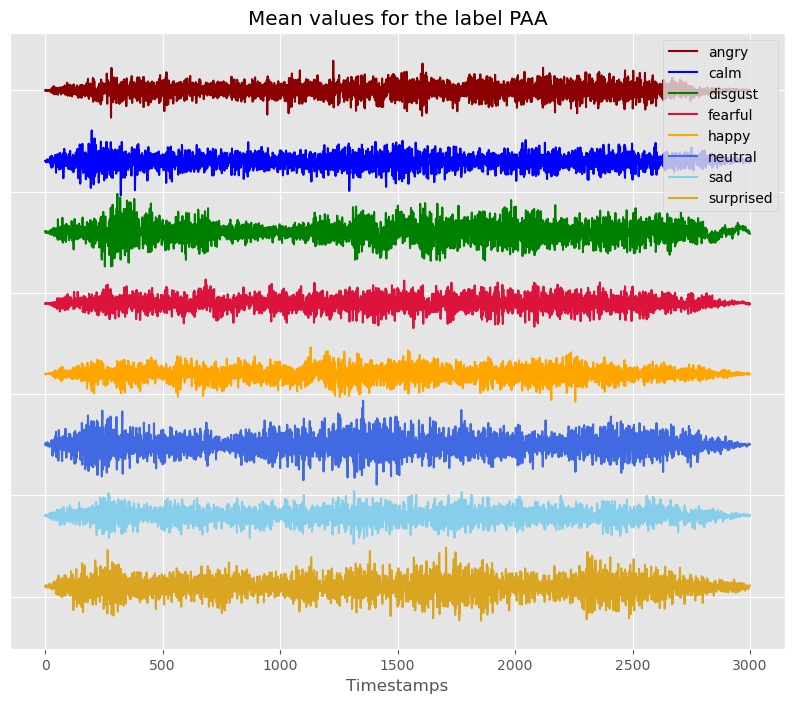

In [49]:
c = ['darkred','blue','green','crimson','orange','royalblue','skyblue','goldenrod']
labels_means = []
for l in labels:
    lm = df_centr[df_centr['emotion'] == l].iloc[:,1:].values.mean(axis=0)
    labels_means.append((l,lm))

plt.figure(figsize = (10,8))
for i,lm in enumerate(labels_means):
    plt.plot(lm[1]+i*-1.4, label = labels_name[i], c = c[i])
    plt.tick_params(left = False, labelleft = False)
    plt.xlabel('Timestamps')
    plt.title(f'Mean values for the label PAA')
    plt.legend()

## K-Means (euclidean)

In [50]:
metric = 'euclidean'

### SAX

In [51]:
n_paa = 150
alphabet_size_avg = 100

sax = SymbolicAggregateApproximation(n_segments = n_paa, alphabet_size_avg = alphabet_size_avg)
ts_sax = sax.fit_transform(Xdf_centr).reshape(len(Xdf_centr), n_paa)

Xdf_centr_sax = pd.DataFrame(sax.inverse_transform(ts_sax).reshape(len(Xdf_centr), len(Xdf_centr.columns)))
Xdf_centr_sax.head()

c:\Users\User\anaconda3\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 366 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '
c:\Users\User\anaconda3\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 366 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,...,2900,2901,2902,2903,2904,2905,2906,2907,2908,2909,2910,2911,2912,2913,2914,2915,2916,2917,2918,2919,2920,2921,2922,2923,2924,2925,2926,2927,2928,2929,2930,2931,2932,2933,2934,2935,2936,2937,2938,2939,2940,2941,2942,2943,2944,2945,2946,2947,2948,2949,2950,2951,2952,2953,2954,2955,2956,2957,2958,2959,2960,2961,2962,2963,2964,2965,2966,2967,2968,2969,2970,2971,2972,2973,2974,2975,2976,2977,2978,2979,2980,2981,2982,2983,2984,2985,2986,2987,2988,2989,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
0,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,-0.113039,-0.113039,-0.113039,-0.113039,-0.113039,-0.113039,-0.113039,-0.113039,-0.113039,-0.113039,-0.113039,-0.113039,-0.113039,-0.113039,-0.113039,-0.113039,-0.113039,-0.113039,-0.113039,-0.113039,...,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533
1,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,...,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.

In [52]:
df_centr_sax = pd.concat([pd.DataFrame(ydf_centr.astype(np.int8).T, columns = ['emotion']), pd.DataFrame(Xdf_centr_sax)], axis=1)
df_centr_sax.head()

,emotion,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,...,2900,2901,2902,2903,2904,2905,2906,2907,2908,2909,2910,2911,2912,2913,2914,2915,2916,2917,2918,2919,2920,2921,2922,2923,2924,2925,2926,2927,2928,2929,2930,2931,2932,2933,2934,2935,2936,2937,2938,2939,2940,2941,2942,2943,2944,2945,2946,2947,2948,2949,2950,2951,2952,2953,2954,2955,2956,2957,2958,2959,2960,2961,2962,2963,2964,2965,2966,2967,2968,2969,2970,2971,2972,2973,2974,2975,2976,2977,2978,2979,2980,2981,2982,2983,2984,2985,2986,2987,2988,2989,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
0,3,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,-0.113039,-0.113039,-0.113039,-0.113039,-0.113039,-0.113039,-0.113039,-0.113039,-0.113039,-0.113039,-0.113039,-0.113039,-0.113039,-0.113039,-0.113039,-0.113039,-0.113039,-0.113039,-0.113039,...,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533
1,0,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,...,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,-0.

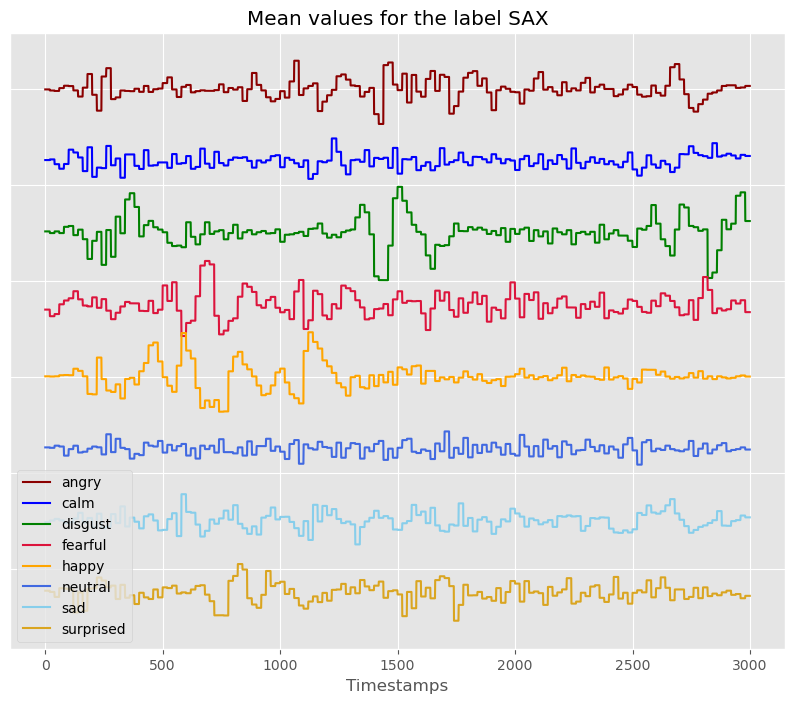

In [53]:
c = ['darkred','blue','green','crimson','orange','royalblue','skyblue','goldenrod']
labels_means = []
for l in labels:
    lm = df_centr_sax[df_centr_sax['emotion'] == l].iloc[:,1:].values.mean(axis=0)
    labels_means.append((l,lm))

plt.figure(figsize = (10,8))
for i,lm in enumerate(labels_means):
    plt.plot(lm[1]+i*-0.15, label = labels_name[i], c = c[i])
    plt.tick_params(left = False, labelleft = False)
    plt.xlabel('Timestamps')
    plt.title(f'Mean values for the label SAX')
    plt.legend()

In [54]:
print('____________________SAX____________________')
print()

# computing kMeans
kmeans_sax = TimeSeriesKMeans(n_clusters=n_clusters, metric=metric, #dtw, softdtw
                      max_iter=50, init='k-means++', random_state=100)
kmeans_sax.fit(Xdf_centr_sax)

____________________SAX____________________



TimeSeriesKMeans(n_clusters=8, random_state=100)

In [55]:
# centroids
centroids_sax = kmeans_sax.cluster_centers_
print('Centroids\' shape',centroids_sax.shape)
print()

Centroids' shape (8, 3000, 1)



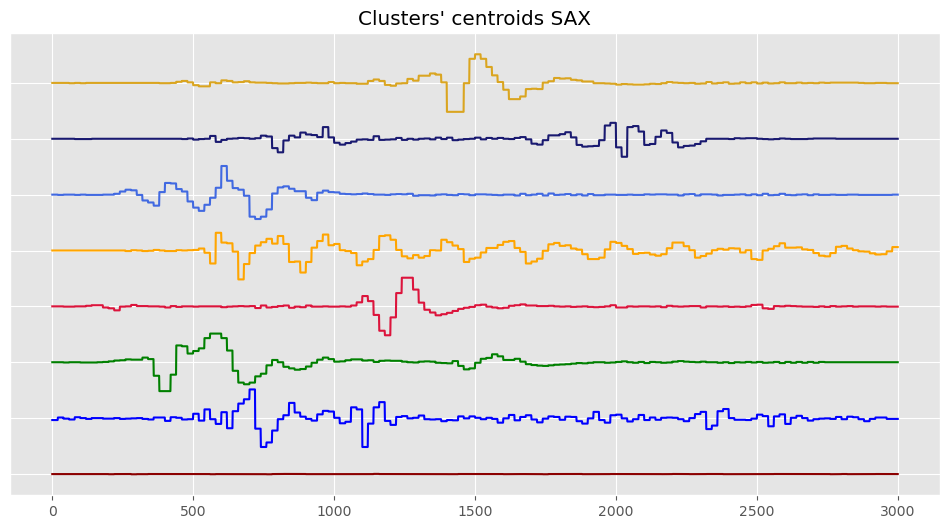

KMeans assigned labels:
 [0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 7
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]



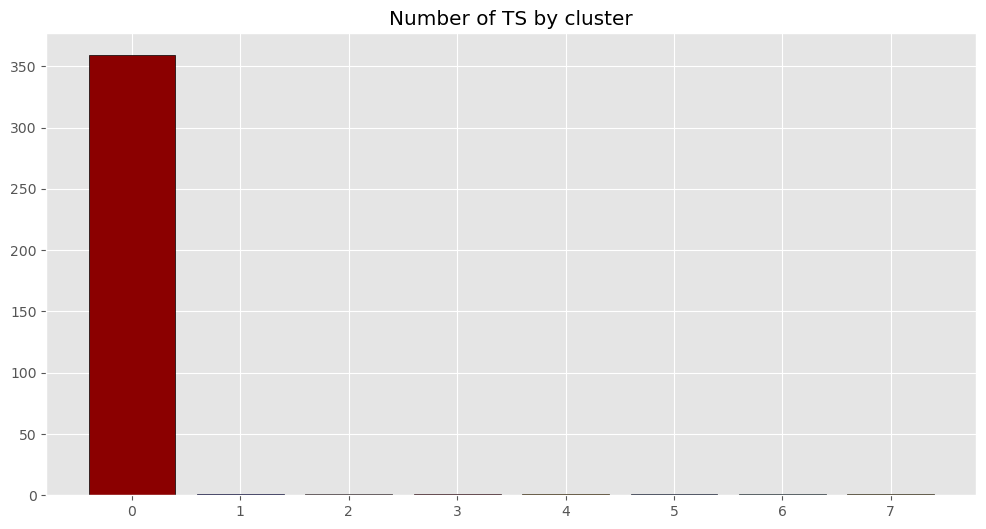


KMeans inertia:  51.88469476359343



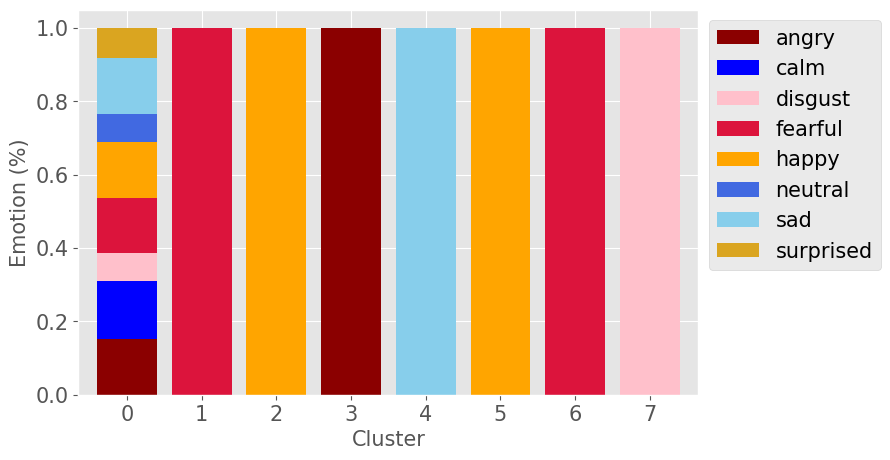



Adjusted_mutual_info_score  = -0.001
Adjusted_rand_score = -0.001
Fowlkes_mallows_score = 0.357
Silhouette_score = 0.611


In [56]:
# inverse transform
df_centroids_sax = np.squeeze(centroids_sax)
colors = ['darkred','blue','green','crimson','orange','royalblue','midnightblue','goldenrod']
# plotting the centroids (disalligned)
for i in range(len(df_centroids_sax)):
#    plt.plot(df_centroids_sax[i], color = colors[i])
#    plt.show()
    c = np.array(df_centroids_sax[i])+ i*5
    plt.plot(c, color = colors[i])
plt.tick_params(left = False, labelleft = False)
plt.title('Clusters\' centroids SAX')
plt.show()

# extracting the labels
km_labels_sax = kmeans_sax.labels_
print('KMeans assigned labels:\n',km_labels_sax)
print()

# n of time series belonging to each cluster
plt.bar(np.unique(km_labels_sax, return_counts=True)[0], np.unique(km_labels_sax, return_counts=True)[1], color = ['darkred','blue','pink','crimson','orange','royalblue','skyblue','goldenrod'], edgecolor = 'k')
plt.title('Number of TS by cluster')
plt.show()
print()

inertia_sax = kmeans_sax.inertia_
print('KMeans inertia: ', inertia_sax)
print()

plot_eval_clust(km_labels_sax, ydf_centr, Xdf_centr_sax)

### PAA

In [57]:
n_segments = 150

paa = PiecewiseAggregateApproximation(n_segments = n_segments)
ts_paa = paa.fit_transform(Xdf_centr).reshape(len(Xdf_centr), n_segments)

Xdf_centr_paa = pd.DataFrame(paa.inverse_transform(ts_paa).reshape(len(Xdf_centr), len(Xdf_centr.columns)))
Xdf_centr_paa.head()

c:\Users\User\anaconda3\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 366 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '
c:\Users\User\anaconda3\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 366 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,...,2900,2901,2902,2903,2904,2905,2906,2907,2908,2909,2910,2911,2912,2913,2914,2915,2916,2917,2918,2919,2920,2921,2922,2923,2924,2925,2926,2927,2928,2929,2930,2931,2932,2933,2934,2935,2936,2937,2938,2939,2940,2941,2942,2943,2944,2945,2946,2947,2948,2949,2950,2951,2952,2953,2954,2955,2956,2957,2958,2959,2960,2961,2962,2963,2964,2965,2966,2967,2968,2969,2970,2971,2972,2973,2974,2975,2976,2977,2978,2979,2980,2981,2982,2983,2984,2985,2986,2987,2988,2989,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
0,-0.006034,-0.006034,-0.006034,-0.006034,-0.006034,-0.006034,-0.006034,-0.006034,-0.006034,-0.006034,-0.006034,-0.006034,-0.006034,-0.006034,-0.006034,-0.006034,-0.006034,-0.006034,-0.006034,-0.006034,-0.024372,-0.024372,-0.024372,-0.024372,-0.024372,-0.024372,-0.024372,-0.024372,-0.024372,-0.024372,-0.024372,-0.024372,-0.024372,-0.024372,-0.024372,-0.024372,-0.024372,-0.024372,-0.024372,-0.024372,0.047784,0.047784,0.047784,0.047784,0.047784,0.047784,0.047784,0.047784,0.047784,0.047784,0.047784,0.047784,0.047784,0.047784,0.047784,0.047784,0.047784,0.047784,0.047784,0.047784,0.035443,0.035443,0.035443,0.035443,0.035443,0.035443,0.035443,0.035443,0.035443,0.035443,0.035443,0.035443,0.035443,0.035443,0.035443,0.035443,0.035443,0.035443,0.035443,0.035443,-0.106845,-0.106845,-0.106845,-0.106845,-0.106845,-0.106845,-0.106845,-0.106845,-0.106845,-0.106845,-0.106845,-0.106845,-0.106845,-0.106845,-0.106845,-0.106845,-0.106845,-0.106845,-0.106845,-0.106845,...,-0.004969,-0.004969,-0.004969,-0.004969,-0.004969,-0.004969,-0.004969,-0.004969,-0.004969,-0.004969,-0.004969,-0.004969,-0.004969,-0.004969,-0.004969,-0.004969,-0.004969,-0.004969,-0.004969,-0.004969,0.001336,0.001336,0.001336,0.001336,0.001336,0.001336,0.001336,0.001336,0.001336,0.001336,0.001336,0.001336,0.001336,0.001336,0.001336,0.001336,0.001336,0.001336,0.001336,0.001336,0.011628,0.011628,0.011628,0.011628,0.011628,0.011628,0.011628,0.011628,0.011628,0.011628,0.011628,0.011628,0.011628,0.011628,0.011628,0.011628,0.011628,0.011628,0.011628,0.011628,-0.008027,-0.008027,-0.008027,-0.008027,-0.008027,-0.008027,-0.008027,-0.008027,-0.008027,-0.008027,-0.008027,-0.008027,-0.008027,-0.008027,-0.008027,-0.008027,-0.008027,-0.008027,-0.008027,-0.008027,0.008258,0.008258,0.008258,0.008258,0.008258,0.008258,0.008258,0.008258,0.008258,0.008258,0.008258,0.008258,0.008258,0.008258,0.008258,0.008258,0.008258,0.008258,0.008258,0.008258
1,0.000386,0.000386,0.000386,0.000386,0.000386,0.000386,0.000386,0.000386,0.000386,0.000386,0.000386,0.000386,0.000386,0.000386,0.000386,0.000386,0.000386,0.000386,0.000386,0.000386,-0.000024,-0.000024,-0.000024,-0.000024,-0.000024,-0.000024,-0.000024,-0.000024,-0.000024,-0.000024,-0.000024,-0.000024,-0.000024,-0.000024,-0.000024,-0.000024,-0.000024,-0.000024,-0.000024,-0.000024,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,0.005925,0.005925,0.005925,0.005925,0.005925,0.005925,0.005925,0.005925,0.005925,0.005925,0.005925,0.005925,0.005925,0.005925,0.005925,0.005925,0.005925,0.005925,0.005925,0.005925,0.012146,0.012146,0.012146,0.012146,0.012146,0.012146,0.012146,0.012146,0.012146,0.012146,0.012146,0.012146,0.012146,0.012146,0.012146,0.012146,0.012146,0.012146,0.012146,0.012146,...,0.000044,0.000044,0.000044,0.000044,0.000044,0.000044,0.000044,0.000044,0.000044,0.000044,0.000044,0.000044,0.000044,0.000044,0.000044,0.000044,0.000044,0.000044,0.000044,0.000044,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,0.

In [58]:
df_centr_paa = pd.concat([pd.DataFrame(ydf_centr.astype(np.int8).T, columns = ['emotion']), pd.DataFrame(Xdf_centr_paa)], axis=1)
df_centr_paa.head()

,emotion,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,...,2900,2901,2902,2903,2904,2905,2906,2907,2908,2909,2910,2911,2912,2913,2914,2915,2916,2917,2918,2919,2920,2921,2922,2923,2924,2925,2926,2927,2928,2929,2930,2931,2932,2933,2934,2935,2936,2937,2938,2939,2940,2941,2942,2943,2944,2945,2946,2947,2948,2949,2950,2951,2952,2953,2954,2955,2956,2957,2958,2959,2960,2961,2962,2963,2964,2965,2966,2967,2968,2969,2970,2971,2972,2973,2974,2975,2976,2977,2978,2979,2980,2981,2982,2983,2984,2985,2986,2987,2988,2989,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
0,3,-0.006034,-0.006034,-0.006034,-0.006034,-0.006034,-0.006034,-0.006034,-0.006034,-0.006034,-0.006034,-0.006034,-0.006034,-0.006034,-0.006034,-0.006034,-0.006034,-0.006034,-0.006034,-0.006034,-0.006034,-0.024372,-0.024372,-0.024372,-0.024372,-0.024372,-0.024372,-0.024372,-0.024372,-0.024372,-0.024372,-0.024372,-0.024372,-0.024372,-0.024372,-0.024372,-0.024372,-0.024372,-0.024372,-0.024372,-0.024372,0.047784,0.047784,0.047784,0.047784,0.047784,0.047784,0.047784,0.047784,0.047784,0.047784,0.047784,0.047784,0.047784,0.047784,0.047784,0.047784,0.047784,0.047784,0.047784,0.047784,0.035443,0.035443,0.035443,0.035443,0.035443,0.035443,0.035443,0.035443,0.035443,0.035443,0.035443,0.035443,0.035443,0.035443,0.035443,0.035443,0.035443,0.035443,0.035443,0.035443,-0.106845,-0.106845,-0.106845,-0.106845,-0.106845,-0.106845,-0.106845,-0.106845,-0.106845,-0.106845,-0.106845,-0.106845,-0.106845,-0.106845,-0.106845,-0.106845,-0.106845,-0.106845,-0.106845,...,-0.004969,-0.004969,-0.004969,-0.004969,-0.004969,-0.004969,-0.004969,-0.004969,-0.004969,-0.004969,-0.004969,-0.004969,-0.004969,-0.004969,-0.004969,-0.004969,-0.004969,-0.004969,-0.004969,-0.004969,0.001336,0.001336,0.001336,0.001336,0.001336,0.001336,0.001336,0.001336,0.001336,0.001336,0.001336,0.001336,0.001336,0.001336,0.001336,0.001336,0.001336,0.001336,0.001336,0.001336,0.011628,0.011628,0.011628,0.011628,0.011628,0.011628,0.011628,0.011628,0.011628,0.011628,0.011628,0.011628,0.011628,0.011628,0.011628,0.011628,0.011628,0.011628,0.011628,0.011628,-0.008027,-0.008027,-0.008027,-0.008027,-0.008027,-0.008027,-0.008027,-0.008027,-0.008027,-0.008027,-0.008027,-0.008027,-0.008027,-0.008027,-0.008027,-0.008027,-0.008027,-0.008027,-0.008027,-0.008027,0.008258,0.008258,0.008258,0.008258,0.008258,0.008258,0.008258,0.008258,0.008258,0.008258,0.008258,0.008258,0.008258,0.008258,0.008258,0.008258,0.008258,0.008258,0.008258,0.008258
1,0,0.000386,0.000386,0.000386,0.000386,0.000386,0.000386,0.000386,0.000386,0.000386,0.000386,0.000386,0.000386,0.000386,0.000386,0.000386,0.000386,0.000386,0.000386,0.000386,0.000386,-0.000024,-0.000024,-0.000024,-0.000024,-0.000024,-0.000024,-0.000024,-0.000024,-0.000024,-0.000024,-0.000024,-0.000024,-0.000024,-0.000024,-0.000024,-0.000024,-0.000024,-0.000024,-0.000024,-0.000024,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,0.005925,0.005925,0.005925,0.005925,0.005925,0.005925,0.005925,0.005925,0.005925,0.005925,0.005925,0.005925,0.005925,0.005925,0.005925,0.005925,0.005925,0.005925,0.005925,0.005925,0.012146,0.012146,0.012146,0.012146,0.012146,0.012146,0.012146,0.012146,0.012146,0.012146,0.012146,0.012146,0.012146,0.012146,0.012146,0.012146,0.012146,0.012146,0.012146,...,0.000044,0.000044,0.000044,0.000044,0.000044,0.000044,0.000044,0.000044,0.000044,0.000044,0.000044,0.000044,0.000044,0.000044,0.000044,0.000044,0.000044,0.000044,0.000044,0.000044,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,0.000174,-0.

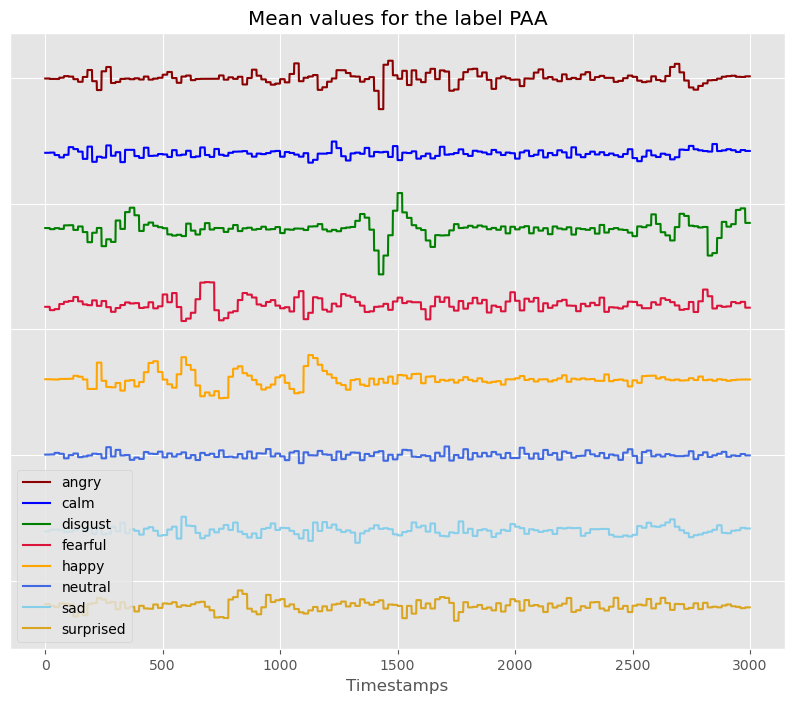

In [59]:
c = ['darkred','blue','green','crimson','orange','royalblue','skyblue','goldenrod']
labels_means = []
for l in labels:
    lm = df_centr_paa[df_centr_paa['emotion'] == l].iloc[:,1:].values.mean(axis=0)
    labels_means.append((l,lm))

plt.figure(figsize = (10,8))
for i,lm in enumerate(labels_means):
    plt.plot(lm[1]+i*-0.3, label = labels_name[i], c = c[i])
    plt.tick_params(left = False, labelleft = False)
    plt.xlabel('Timestamps')
    plt.title(f'Mean values for the label PAA')
    plt.legend()

In [60]:
print('____________________PAA____________________')
print()

# computing kMeans
kmeans_paa = TimeSeriesKMeans(n_clusters=n_clusters, metric=metric, #dtw, softdtw
                      max_iter=50, init='k-means++', random_state=100)
kmeans_paa.fit(Xdf_centr_paa)

____________________PAA____________________



TimeSeriesKMeans(n_clusters=8, random_state=100)

In [61]:
# centroids
centroids_paa = kmeans_paa.cluster_centers_
print('Centroids\' shape',centroids_paa.shape)
print()

Centroids' shape (8, 3000, 1)



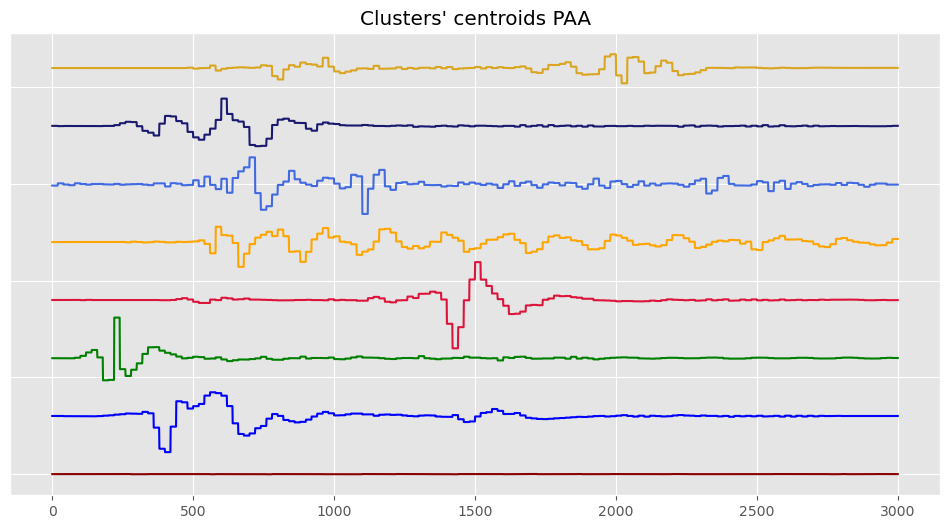

KMeans assigned labels:
 [0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 2
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]



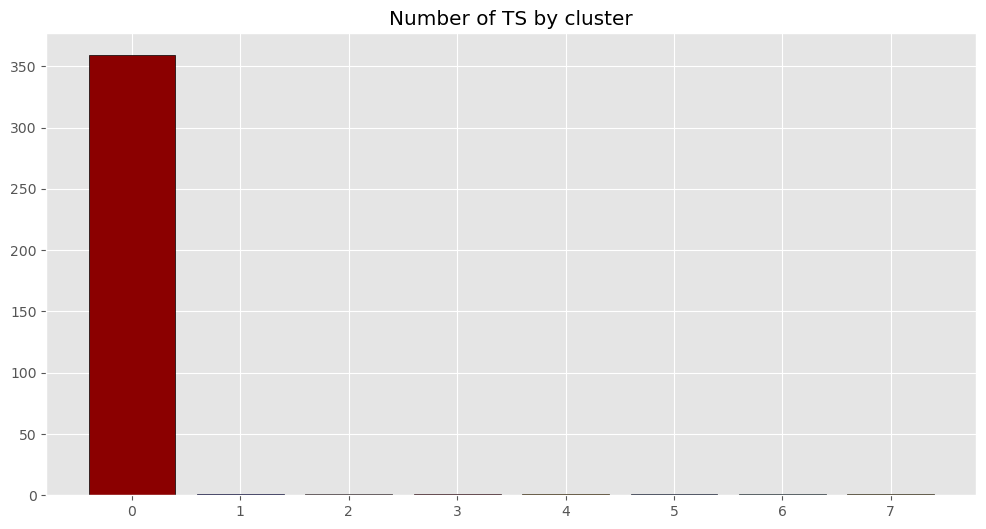


KMeans inertia:  55.79355129369736



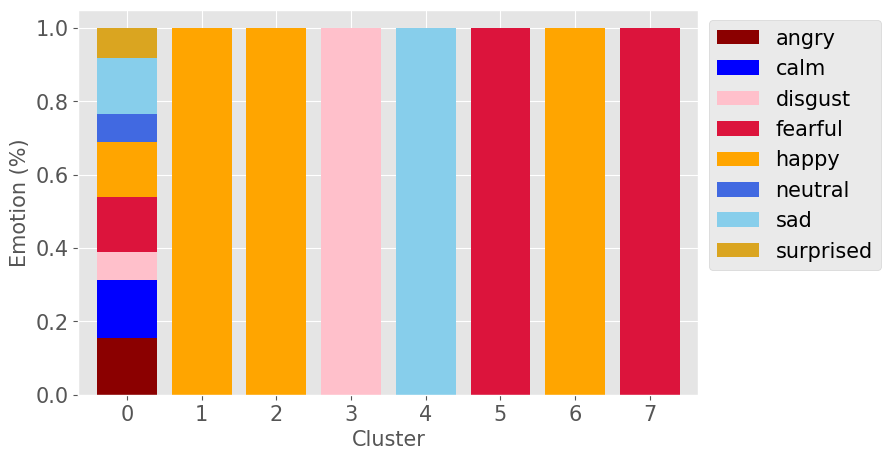



Adjusted_mutual_info_score  = -0.001
Adjusted_rand_score = -0.001
Fowlkes_mallows_score = 0.357
Silhouette_score = 0.607


In [62]:
# inverse transform
df_centroids_paa = np.squeeze(centroids_paa)
colors = ['darkred','blue','green','crimson','orange','royalblue','midnightblue','goldenrod']

# plotting the centroids (disalligned)
for i in range(len(df_centroids_paa)):
    #plt.plot(df_centroids_paa[i], color = colors[i])
    #plt.show()
    c = np.array(df_centroids_paa[i])+ i*6
    plt.plot(c, color = colors[i])
plt.tick_params(left = False, labelleft = False)
plt.title('Clusters\' centroids PAA')
plt.show()

# extracting the labels
km_labels_paa = kmeans_paa.labels_
print('KMeans assigned labels:\n',km_labels_paa)
print()

# n of time series belonging to each cluster
plt.bar(np.unique(km_labels_paa, return_counts=True)[0], np.unique(km_labels_paa, return_counts=True)[1], color = ['darkred','blue','pink','crimson','orange','royalblue','skyblue','goldenrod'], edgecolor = 'k')
plt.title('Number of TS by cluster')
plt.show()
print()

inertia_paa = kmeans_paa.inertia_
print('KMeans inertia: ', inertia_paa)
print()

plot_eval_clust(km_labels_paa, ydf_centr, Xdf_centr_paa)

### DFT

In [63]:
n_coefs = 150

dft = DiscreteFourierTransform(n_coefs=n_coefs)
ts_dft = dft.fit_transform(Xdf_centr)

Xdf_centr_dft = pd.DataFrame(dft_inverse_trasform(ts_dft, n_coefs=n_coefs, n_timestamps=len(Xdf_centr.columns)))
Xdf_centr_dft.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,...,2900,2901,2902,2903,2904,2905,2906,2907,2908,2909,2910,2911,2912,2913,2914,2915,2916,2917,2918,2919,2920,2921,2922,2923,2924,2925,2926,2927,2928,2929,2930,2931,2932,2933,2934,2935,2936,2937,2938,2939,2940,2941,2942,2943,2944,2945,2946,2947,2948,2949,2950,2951,2952,2953,2954,2955,2956,2957,2958,2959,2960,2961,2962,2963,2964,2965,2966,2967,2968,2969,2970,2971,2972,2973,2974,2975,2976,2977,2978,2979,2980,2981,2982,2983,2984,2985,2986,2987,2988,2989,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
0,0.007263,0.006990,0.006665,0.006289,0.005869,0.005409,0.004913,0.004390,0.003844,0.003283,0.002712,0.002140,0.001571,0.001014,0.000474,-0.000044,-0.000535,-0.000993,-0.001414,-0.001797,-0.002138,-0.002435,-0.002688,-0.002897,-0.003062,-0.003184,-0.003267,-0.003312,-0.003324,-0.003305,-0.003261,-0.003195,-0.003112,-0.003018,-0.002917,-0.002813,-0.002712,-0.002617,-0.002532,-0.002462,-0.002408,-0.002373,-0.002359,-0.002367,-0.002397,-0.002450,-0.002525,-0.002620,-0.002733,-0.002862,-0.003005,-0.003159,-0.003319,-0.003483,-0.003646,-0.003805,-0.003956,-0.004097,-0.004222,-0.004330,-0.004418,-0.004484,-0.004525,-0.004541,-0.004531,-0.004494,-0.004431,-0.004343,-0.004230,-0.004096,-0.003941,-0.003768,-0.003581,-0.003381,-0.003173,-0.002960,-0.002745,-0.002531,-0.002322,-0.002120,-0.001928,-0.001749,-0.001584,-0.001436,-0.001306,-0.001194,-0.001101,-0.001026,-0.000970,-0.000932,-0.000910,-0.000902,-0.000908,-0.000924,-0.000948,-0.000979,-0.001012,-0.001047,-0.001080,-0.001109,...,0.000293,0.000206,0.000107,-3.273251e-07,-0.000115,-0.000235,-0.000359,-0.000484,-0.000608,-0.000729,-0.000846,-0.000956,-0.001058,-0.001150,-0.001231,-0.001299,-0.001353,-0.001392,-0.001416,-0.001423,-0.001413,-0.001387,-0.001343,-0.001283,-0.001207,-0.001116,-0.001010,-0.000890,-0.000759,-0.000617,-0.000466,-0.000307,-0.000144,0.000023,0.000191,0.000357,0.000520,0.000677,0.000826,0.000965,0.001092,0.001205,0.001302,0.001381,0.001442,0.001482,0.001502,0.001500,0.001477,0.001434,0.001369,0.001286,0.001184,0.001066,0.000934,0.000791,0.000639,0.000481,0.000321,0.000163,0.000009,-0.000135,-0.000266,-0.000380,-0.000474,-0.000543,-0.000585,-0.000597,-0.000575,-0.000517,-0.000423,-0.000289,-0.000117,0.000095,0.000345,0.000632,0.000955,0.001310,0.001695,0.002105,0.002537,0.002985,0.003444,0.003908,0.004372,0.004830,0.005274,0.005699,0.006099,0.006468,0.006801,0.007091,0.007334,0.007527,0.007666,0.007748,0.007771,0.007734,0.007636,0.007479
1,-0.000053,-0.000048,-0.000045,-0.000043,-0.000043,-0.000044,-0.000047,-0.000052,-0.000059,-0.000067,-0.000076,-0.000086,-0.000097,-0.000109,-0.000120,-0.000131,-0.000142,-0.000152,-0.000160,-0.000167,-0.000173,-0.000176,-0.000177,-0.000176,-0.000173,-0.000167,-0.000160,-0.000150,-0.000138,-0.000125,-0.000111,-0.000095,-0.000079,-0.000062,-0.000045,-0.000029,-0.000012,0.000004,0.000019,0.000033,0.000046,0.000058,0.000069,0.000080,0.000090,0.000099,0.000109,0.000119,0.000129,0.000141,0.000154,0.000169,0.000186,0.000205,0.000227,0.000252,0.000278,0.000308,0.000339,0.000372,0.000407,0.000442,0.000476,0.000509,0.000540,0.000567,0.000589,0.000604,0.000612,0.000611,0.000600,0.000577,0.000540,0.000490,0.000425,0.000344,0.000247,0.000134,0.000004,-0.000141,-0.000302,-0.000477,-0.000664,-0.000862,-0.001069,-0.001282,-0.001499,-0.001717,-0.001932,-0.002142,-0.002343,-0.002531,-0.002703,-0.002856,-0.002986,-0.003089,-0.003165,-0.003209,-0.003219,-0.003194,...,-0.000176,-0.000179,-0.000178,-1.743000e-04,-0.000167,-0.000156,-0.000142,-0.000125,-0.000105,-0.000083,-0.000059,-0.000034,-0.000007,0.000020,0.000047,0.000073,0.000097,0.000120,0.000140,0.000158,0.000172,0.000183,0.000189,0.000191,0.000189,0.000183,0.000172,0.000157,0.000138,0.000116,0.000090,0.000061

In [64]:
df_centr_dft = pd.concat([pd.DataFrame(ydf_centr.astype(np.int8).T, columns = ['emotion']), pd.DataFrame(Xdf_centr_dft)], axis=1)
df_centr_dft.head()

,emotion,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,...,2900,2901,2902,2903,2904,2905,2906,2907,2908,2909,2910,2911,2912,2913,2914,2915,2916,2917,2918,2919,2920,2921,2922,2923,2924,2925,2926,2927,2928,2929,2930,2931,2932,2933,2934,2935,2936,2937,2938,2939,2940,2941,2942,2943,2944,2945,2946,2947,2948,2949,2950,2951,2952,2953,2954,2955,2956,2957,2958,2959,2960,2961,2962,2963,2964,2965,2966,2967,2968,2969,2970,2971,2972,2973,2974,2975,2976,2977,2978,2979,2980,2981,2982,2983,2984,2985,2986,2987,2988,2989,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
0,3,0.007263,0.006990,0.006665,0.006289,0.005869,0.005409,0.004913,0.004390,0.003844,0.003283,0.002712,0.002140,0.001571,0.001014,0.000474,-0.000044,-0.000535,-0.000993,-0.001414,-0.001797,-0.002138,-0.002435,-0.002688,-0.002897,-0.003062,-0.003184,-0.003267,-0.003312,-0.003324,-0.003305,-0.003261,-0.003195,-0.003112,-0.003018,-0.002917,-0.002813,-0.002712,-0.002617,-0.002532,-0.002462,-0.002408,-0.002373,-0.002359,-0.002367,-0.002397,-0.002450,-0.002525,-0.002620,-0.002733,-0.002862,-0.003005,-0.003159,-0.003319,-0.003483,-0.003646,-0.003805,-0.003956,-0.004097,-0.004222,-0.004330,-0.004418,-0.004484,-0.004525,-0.004541,-0.004531,-0.004494,-0.004431,-0.004343,-0.004230,-0.004096,-0.003941,-0.003768,-0.003581,-0.003381,-0.003173,-0.002960,-0.002745,-0.002531,-0.002322,-0.002120,-0.001928,-0.001749,-0.001584,-0.001436,-0.001306,-0.001194,-0.001101,-0.001026,-0.000970,-0.000932,-0.000910,-0.000902,-0.000908,-0.000924,-0.000948,-0.000979,-0.001012,-0.001047,-0.001080,...,0.000293,0.000206,0.000107,-3.273251e-07,-0.000115,-0.000235,-0.000359,-0.000484,-0.000608,-0.000729,-0.000846,-0.000956,-0.001058,-0.001150,-0.001231,-0.001299,-0.001353,-0.001392,-0.001416,-0.001423,-0.001413,-0.001387,-0.001343,-0.001283,-0.001207,-0.001116,-0.001010,-0.000890,-0.000759,-0.000617,-0.000466,-0.000307,-0.000144,0.000023,0.000191,0.000357,0.000520,0.000677,0.000826,0.000965,0.001092,0.001205,0.001302,0.001381,0.001442,0.001482,0.001502,0.001500,0.001477,0.001434,0.001369,0.001286,0.001184,0.001066,0.000934,0.000791,0.000639,0.000481,0.000321,0.000163,0.000009,-0.000135,-0.000266,-0.000380,-0.000474,-0.000543,-0.000585,-0.000597,-0.000575,-0.000517,-0.000423,-0.000289,-0.000117,0.000095,0.000345,0.000632,0.000955,0.001310,0.001695,0.002105,0.002537,0.002985,0.003444,0.003908,0.004372,0.004830,0.005274,0.005699,0.006099,0.006468,0.006801,0.007091,0.007334,0.007527,0.007666,0.007748,0.007771,0.007734,0.007636,0.007479
1,0,-0.000053,-0.000048,-0.000045,-0.000043,-0.000043,-0.000044,-0.000047,-0.000052,-0.000059,-0.000067,-0.000076,-0.000086,-0.000097,-0.000109,-0.000120,-0.000131,-0.000142,-0.000152,-0.000160,-0.000167,-0.000173,-0.000176,-0.000177,-0.000176,-0.000173,-0.000167,-0.000160,-0.000150,-0.000138,-0.000125,-0.000111,-0.000095,-0.000079,-0.000062,-0.000045,-0.000029,-0.000012,0.000004,0.000019,0.000033,0.000046,0.000058,0.000069,0.000080,0.000090,0.000099,0.000109,0.000119,0.000129,0.000141,0.000154,0.000169,0.000186,0.000205,0.000227,0.000252,0.000278,0.000308,0.000339,0.000372,0.000407,0.000442,0.000476,0.000509,0.000540,0.000567,0.000589,0.000604,0.000612,0.000611,0.000600,0.000577,0.000540,0.000490,0.000425,0.000344,0.000247,0.000134,0.000004,-0.000141,-0.000302,-0.000477,-0.000664,-0.000862,-0.001069,-0.001282,-0.001499,-0.001717,-0.001932,-0.002142,-0.002343,-0.002531,-0.002703,-0.002856,-0.002986,-0.003089,-0.003165,-0.003209,-0.003219,...,-0.000176,-0.000179,-0.000178,-1.743000e-04,-0.000167,-0.000156,-0.000142,-0.000125,-0.000105,-0.000083,-0.000059,-0.000034,-0.000007,0.000020,0.000047,0.000073,0.000097,0.000120,0.000140,0.000158,0.000172,0.000183,0.000189,0.000191,0.000189,0.000183,0.000172,0.000157,0.000138,0.000116,0.000090,0.000061,0.000030,-

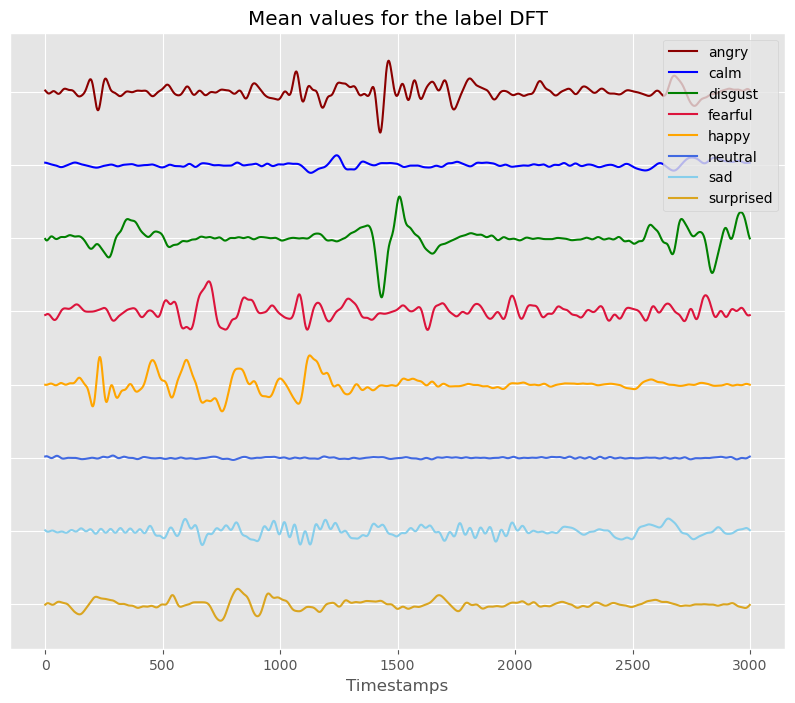

In [65]:
c = ['darkred','blue','green','crimson','orange','royalblue','skyblue','goldenrod']
labels_means = []
for l in labels:
    lm = df_centr_dft[df_centr_dft['emotion'] == l].iloc[:,1:].values.mean(axis=0)
    labels_means.append((l,lm))

plt.figure(figsize = (10,8))
for i,lm in enumerate(labels_means):
    plt.plot(lm[1]+i*-0.25, label = labels_name[i], c = c[i])
    plt.tick_params(left = False, labelleft = False)
    plt.xlabel('Timestamps')
    plt.title(f'Mean values for the label DFT')
    plt.legend()

In [66]:
print('____________________DFT____________________')
print()

# computing kMeans
kmeans_dft = TimeSeriesKMeans(n_clusters=n_clusters, metric=metric, #dtw, softdtw
                      max_iter=50, init='k-means++', random_state=100)
kmeans_dft.fit(Xdf_centr_dft)

____________________DFT____________________



TimeSeriesKMeans(n_clusters=8, random_state=100)

In [67]:
# centroids
centroids_dft = kmeans_dft.cluster_centers_
print('Centroids\' shape',centroids_dft.shape)
print()

Centroids' shape (8, 3000, 1)



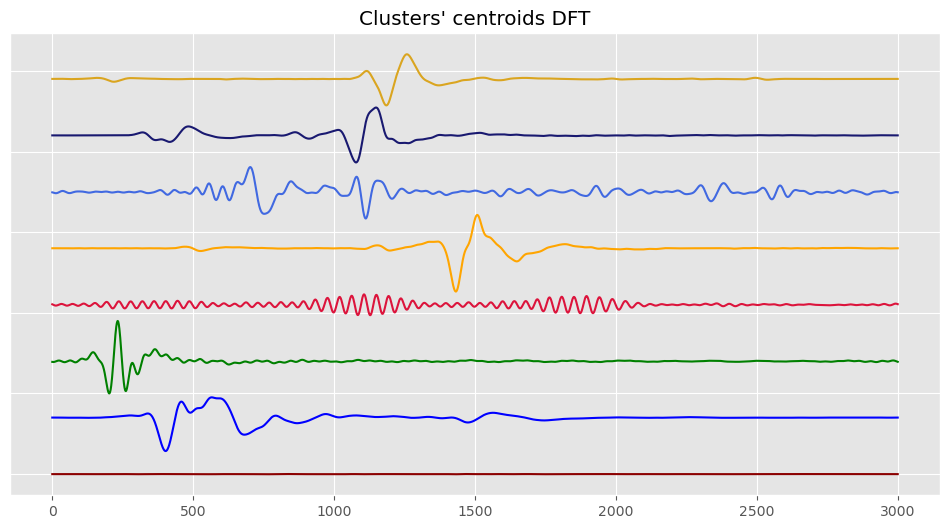

KMeans assigned labels:
 [0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 2
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 0 0 0 4
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 6 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]



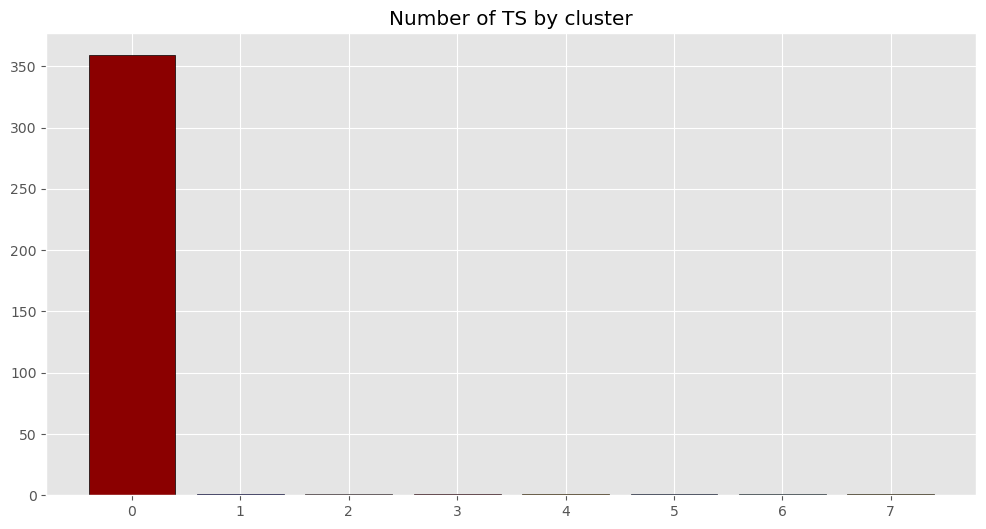


KMeans inertia:  48.913153758657835



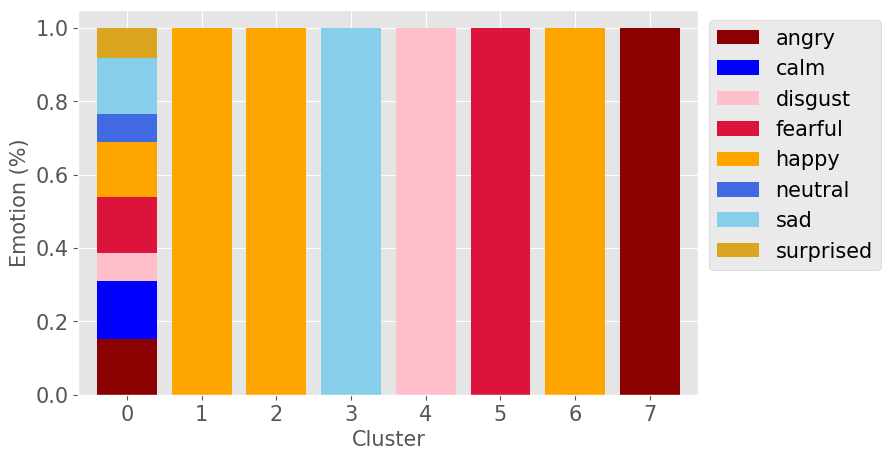



Adjusted_mutual_info_score  = -0.001
Adjusted_rand_score = -0.001
Fowlkes_mallows_score = 0.357
Silhouette_score = 0.723


In [68]:
# inverse transform
df_centroids_dft = np.squeeze(centroids_dft)
colors = ['darkred','blue','green','crimson','orange','royalblue','midnightblue','goldenrod']

# plotting the centroids (disalligned)
for i in range(len(df_centroids_dft)):
#    plt.plot(df_centroids_dft[i], color = colors[i])
#    plt.show()
    c = np.array(df_centroids_dft[i])+ i*7
    plt.plot(c, color = colors[i])
plt.tick_params(left = False, labelleft = False)
plt.title('Clusters\' centroids DFT')
plt.show()

# extracting the labels
km_labels_dft = kmeans_dft.labels_
print('KMeans assigned labels:\n',km_labels_dft)
print()

# n of time series belonging to each cluster
plt.bar(np.unique(km_labels_dft, return_counts=True)[0], np.unique(km_labels_dft, return_counts=True)[1], color = ['darkred','blue','pink','crimson','orange','royalblue','skyblue','goldenrod'], edgecolor = 'k')
plt.title('Number of TS by cluster')
plt.show()
print()

inertia_dft = kmeans_dft.inertia_
print('KMeans inertia: ', inertia_dft)
print()

plot_eval_clust(km_labels_dft, ydf_centr, Xdf_centr_dft)

## K-Means (DTW)

In [69]:
max_iter = 5
max_iter_barycenter = 5
fraction = 0.2
n_clusters = 8
metric = 'dtw'

In [70]:
X_centr, y_centr, df_centr = imp_for_centroids('data_ts\data_dec_scld.csv', fraction = fraction, emotions = n_clusters)
Xdf_centr, ydf_centr = df_centr.iloc[:,1:], df_centr.iloc[:,0]
print(X_centr.shape, y_centr.shape)
print(Xdf_centr.shape, ydf_centr.shape)

df_centr.head()

['fearful' 'disgust' 'neutral' 'happy' 'calm' 'surprised' 'sad' 'angry']
(366, 3000) (366,)
(366, 3000) (366,)


,emotion,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,...,2900,2901,2902,2903,2904,2905,2906,2907,2908,2909,2910,2911,2912,2913,2914,2915,2916,2917,2918,2919,2920,2921,2922,2923,2924,2925,2926,2927,2928,2929,2930,2931,2932,2933,2934,2935,2936,2937,2938,2939,2940,2941,2942,2943,2944,2945,2946,2947,2948,2949,2950,2951,2952,2953,2954,2955,2956,2957,2958,2959,2960,2961,2962,2963,2964,2965,2966,2967,2968,2969,2970,2971,2972,2973,2974,2975,2976,2977,2978,2979,2980,2981,2982,2983,2984,2985,2986,2987,2988,2989,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
0,3,0.053089,-0.032862,0.024607,-0.015404,-0.101163,0.064593,-0.001025,0.066360,0.091200,-0.077449,0.054618,-0.037371,-0.081749,0.019922,-0.013117,0.026027,0.020913,0.056697,-0.139390,-0.099169,0.087688,0.105028,0.284684,-0.100427,0.038835,-0.751446,-0.670507,1.256607,0.393322,0.534788,-0.591166,-1.905436,0.748771,0.686192,0.348554,0.589916,0.080985,-1.262934,-1.456496,1.095604,0.928102,0.323666,0.594571,-0.809248,-1.894475,0.228025,1.402733,0.432078,0.716536,-0.791504,-1.989240,0.217213,1.140047,0.573860,0.598413,-0.233827,-1.759500,-0.571482,1.130160,0.719560,0.796177,-0.255059,-1.881244,-0.358118,0.840578,0.691819,1.009061,-0.429927,-1.847673,-0.212428,0.886662,0.611637,0.938294,-0.352288,-1.730439,-0.491996,0.702574,0.861927,1.034171,-0.104871,-1.953356,-0.705426,0.909710,0.732205,1.041082,-0.008643,-1.773529,-0.738245,0.582804,0.714225,1.029784,0.101340,-1.407056,-0.813339,0.296805,0.622757,1.046952,0.232090,-1.297789,...,-0.290573,0.058693,0.386201,0.280671,-0.128657,-0.440344,-0.304100,0.173746,0.477526,0.297397,-0.228352,-0.537989,-0.238935,0.312166,0.486853,0.212302,-0.297139,-0.528027,-0.106324,0.315502,0.367440,0.132736,-0.317562,-0.354163,0.018680,0.230443,0.243355,-0.024758,-0.274083,-0.102511,0.113629,0.157863,0.063315,-0.121096,-0.153185,0.034127,0.153109,0.041800,-0.067969,-0.114439,0.010854,0.138478,-0.052741,-0.064443,0.060331,0.000922,0.004435,-0.048679,-0.011854,0.121524,-0.005138,-0.135464,-0.038328,0.141051,0.115968,-0.059176,-0.147104,-0.069462,0.152759,0.118620,-0.092016,-0.123930,-0.033493,0.115507,0.101762,-0.064833,-0.103894,-0.008772,0.088585,0.072070,-0.069536,-0.090803,0.065217,0.081671,-0.056188,-0.067127,0.045464,0.055835,-0.032535,-0.043521,0.026670,0.019534,0.008420,0.024240,-0.045691,-0.000348,0.061081,-0.039343,-0.031359,0.065203,0.018481,-0.062780,0.022315,0.050581,-0.050820,0.005783,0.044985,-0.003515,0.025598,0.026129
1,0,0.004251,0.000212,0.002298,0.002055,-0.001524,-0.001179,0.002953,-0.002744,0.002639,0.005505,-0.011955,-0.001212,0.012329,-0.008041,-0.012153,0.011467,0.008081,-0.018099,-0.006105,0.018936,-0.000626,-0.022451,0.001422,0.019523,-0.006274,-0.023228,0.005145,0.026465,-0.003297,-0.023837,0.004878,0.026395,0.004323,-0.023575,-0.005874,0.025805,0.011135,-0.019446,-0.013544,0.016584,0.015555,-0.016661,-0.011111,0.012465,-0.001280,-0.011268,0.002902,0.006969,-0.004501,-0.002834,0.006127,-0.006665,-0.004037,0.009409,-0.005183,-0.004597,0.006824,0.000553,0.003160,0.000378,-0.002159,0.009271,0.003405,0.004937,-0.001774,-0.014975,0.000075,-0.011918,-0.003423,-0.011126,-0.016847,0.009075,-0.016381,0.011939,-0.020904,0.072008,0.125691,-0.046839,0.059535,-0.031090,-0.056921,0.121369,-0.094797,-0.113328,-0.025698,-0.078255,-0.022950,0.029100,-0.009177,0.021025,0.032394,0.000066,0.148589,0.005317,-0.043260,0.095096,-0.077079,-0.131573,0.080423,...,-0.000217,0.002317,0.000531,0.001338,0.000061,0.004942,0.004565,-0.001362,0.000408,-0.000838,-0.001423,-0.004027,-0.004717,0.000154,-0.001985,-0.003478,-0.000425,0.002917,0.000999,0.001111,0.001845,0.001244,0.003920,0.001906,0.004467,0.002395,0.000069,0.002999,-0.002776,-0.002318,-0.000488,-0.001519,-0.003738,-0.003906,0.003570,-0.001718,-0.005960,0.002505,0.0

### SAX

In [71]:
n_paa = 150
alphabet_size_avg = 100

sax = SymbolicAggregateApproximation(n_segments = n_paa, alphabet_size_avg = alphabet_size_avg)
ts_sax = sax.fit_transform(Xdf_centr).reshape(len(Xdf_centr), n_paa)

Xdf_centr_sax = pd.DataFrame(sax.inverse_transform(ts_sax).reshape(len(Xdf_centr), len(Xdf_centr.columns)))
Xdf_centr_sax.head()

c:\Users\User\anaconda3\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 366 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '
c:\Users\User\anaconda3\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 366 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,...,2900,2901,2902,2903,2904,2905,2906,2907,2908,2909,2910,2911,2912,2913,2914,2915,2916,2917,2918,2919,2920,2921,2922,2923,2924,2925,2926,2927,2928,2929,2930,2931,2932,2933,2934,2935,2936,2937,2938,2939,2940,2941,2942,2943,2944,2945,2946,2947,2948,2949,2950,2951,2952,2953,2954,2955,2956,2957,2958,2959,2960,2961,2962,2963,2964,2965,2966,2967,2968,2969,2970,2971,2972,2973,2974,2975,2976,2977,2978,2979,2980,2981,2982,2983,2984,2985,2986,2987,2988,2989,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
0,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,-0.113039,-0.113039,-0.113039,-0.113039,-0.113039,-0.113039,-0.113039,-0.113039,-0.113039,-0.113039,-0.113039,-0.113039,-0.113039,-0.113039,-0.113039,-0.113039,-0.113039,-0.113039,-0.113039,-0.113039,...,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533
1,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,...,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.

In [72]:
print('____________________SAX____________________')
print()

# computing kMeans
#kmeans_sax = TimeSeriesKMeans(n_clusters=n_clusters, metric=metric, #dtw, softdtw
#                      max_iter=max_iter, init='k-means++', random_state=100, max_iter_barycenter = max_iter_barycenter)
#kmeans_sax.fit(Xdf_centr_sax)

____________________SAX____________________



In [73]:
#joblib.dump(kmeans_sax, 'kmeans_sax_3000.joblib')

In [74]:
kmeans_sax = joblib.load('data_ts\kmeans_sax_3000.joblib')

In [75]:
# centroids
centroids_sax = kmeans_sax.cluster_centers_
print('Centroids\' shape',centroids_sax.shape)
print()

Centroids' shape (8, 3000, 1)



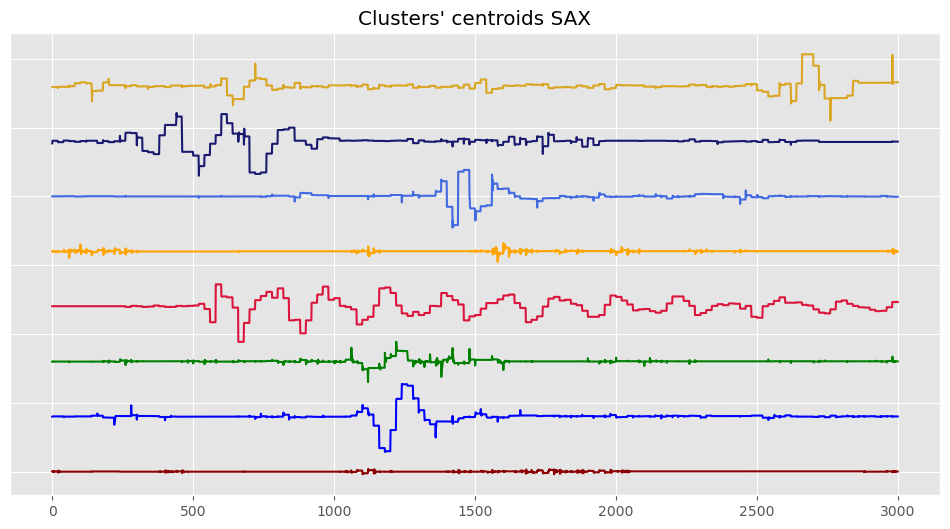

KMeans assigned labels:
 [0 0 0 3 0 0 0 0 0 0 4 0 4 0 0 0 0 0 0 0 0 0 0 0 5 2 0 4 0 0 0 0 0 0 4 0 0
 1 0 0 4 0 0 0 0 0 4 4 0 0 0 0 0 4 0 4 0 0 4 0 0 0 4 4 0 0 0 0 1 0 0 4 0 5
 0 0 0 4 0 4 2 0 0 4 0 4 4 0 0 4 0 0 0 0 0 0 0 2 0 2 4 0 4 0 1 1 0 0 0 0 0
 4 0 0 0 0 6 0 0 0 4 0 5 5 0 4 0 0 0 0 0 0 4 2 4 2 0 0 0 0 0 4 1 0 4 0 0 0
 4 4 0 0 4 0 4 0 0 0 4 0 0 2 0 0 0 0 0 0 0 0 0 2 4 0 0 2 0 4 0 4 1 2 0 0 1
 0 0 4 0 0 0 4 0 0 0 4 0 4 4 0 0 0 2 4 0 2 0 0 0 0 4 0 0 2 0 0 0 0 2 0 0 0
 4 0 0 0 0 6 4 0 4 0 4 0 0 4 0 0 0 0 0 0 0 2 0 0 4 0 0 0 0 7 4 0 0 0 0 0 0
 4 2 0 0 7 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 4 0 7 0 4 0 0 2 0 0 4 0 0 4 0 0 0
 4 2 0 0 0 0 0 0 0 4 0 0 2 0 0 0 0 4 0 0 0 0 0 4 0 0 0 4 0 0 0 0 0 1 0 0 4
 0 0 0 5 0 0 0 0 0 0 0 0 4 0 0 0 0 0 2 0 4 4 0 0 0 0 4 0 4 0 0 2 4]



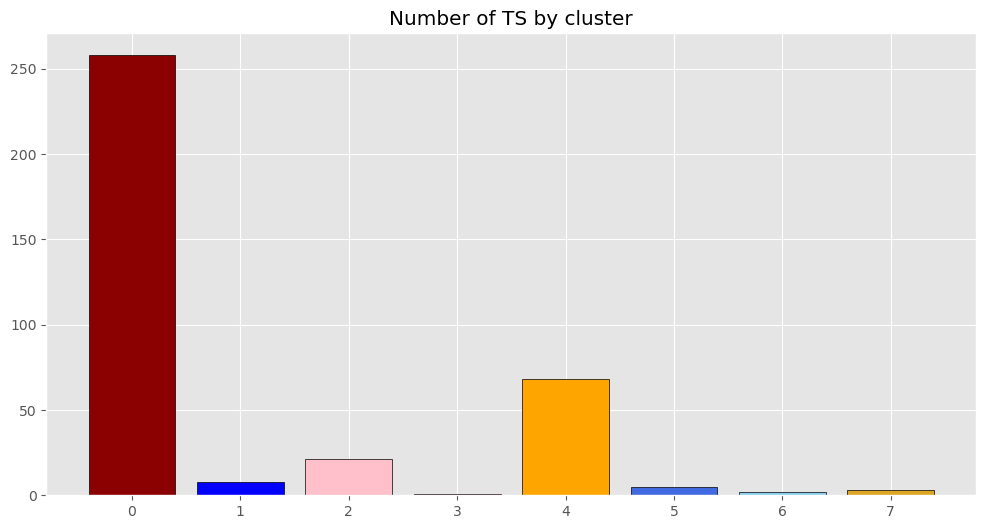


KMeans inertia:  8.981830093407508



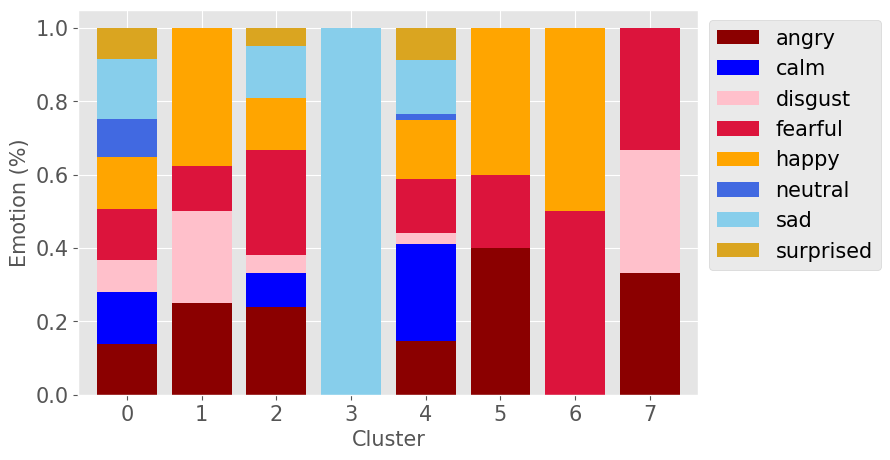



Adjusted_mutual_info_score  = 0.01
Adjusted_rand_score = -0.008
Fowlkes_mallows_score = 0.259
Silhouette_score = 0.226


In [76]:
# inverse transform
df_centroids_sax = np.squeeze(centroids_sax)
colors = ['darkred','blue','green','crimson','orange','royalblue','midnightblue','goldenrod']
# plotting the centroids (disalligned)
for i in range(len(df_centroids_sax)):
#    plt.plot(df_centroids_sax[i], color = colors[i])
#    plt.show()
    c = np.array(df_centroids_sax[i])+ i*4
    plt.plot(c, color = colors[i])
plt.tick_params(left = False, labelleft = False)
plt.title('Clusters\' centroids SAX')
plt.show()

# extracting the labels
km_labels_sax = kmeans_sax.labels_
print('KMeans assigned labels:\n',km_labels_sax)
print()

# n of time series belonging to each cluster
plt.bar(np.unique(km_labels_sax, return_counts=True)[0], np.unique(km_labels_sax, return_counts=True)[1], color = ['darkred','blue','pink','crimson','orange','royalblue','skyblue','goldenrod'], edgecolor = 'k')
plt.title('Number of TS by cluster')
plt.show()
print()

inertia_sax = kmeans_sax.inertia_
print('KMeans inertia: ', inertia_sax)
print()

plot_eval_clust(km_labels_sax, ydf_centr, Xdf_centr_sax)

### DFT

In [77]:
n_coefs = 150

dft = DiscreteFourierTransform(n_coefs=n_coefs)
ts_dft = dft.fit_transform(Xdf_centr)

Xdf_centr_dft = pd.DataFrame(dft_inverse_trasform(ts_dft, n_coefs=n_coefs, n_timestamps=len(Xdf_centr.columns)))
Xdf_centr_dft.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,...,2900,2901,2902,2903,2904,2905,2906,2907,2908,2909,2910,2911,2912,2913,2914,2915,2916,2917,2918,2919,2920,2921,2922,2923,2924,2925,2926,2927,2928,2929,2930,2931,2932,2933,2934,2935,2936,2937,2938,2939,2940,2941,2942,2943,2944,2945,2946,2947,2948,2949,2950,2951,2952,2953,2954,2955,2956,2957,2958,2959,2960,2961,2962,2963,2964,2965,2966,2967,2968,2969,2970,2971,2972,2973,2974,2975,2976,2977,2978,2979,2980,2981,2982,2983,2984,2985,2986,2987,2988,2989,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
0,0.007263,0.006990,0.006665,0.006289,0.005869,0.005409,0.004913,0.004390,0.003844,0.003283,0.002712,0.002140,0.001571,0.001014,0.000474,-0.000044,-0.000535,-0.000993,-0.001414,-0.001797,-0.002138,-0.002435,-0.002688,-0.002897,-0.003062,-0.003184,-0.003267,-0.003312,-0.003324,-0.003305,-0.003261,-0.003195,-0.003112,-0.003018,-0.002917,-0.002813,-0.002712,-0.002617,-0.002532,-0.002462,-0.002408,-0.002373,-0.002359,-0.002367,-0.002397,-0.002450,-0.002525,-0.002620,-0.002733,-0.002862,-0.003005,-0.003159,-0.003319,-0.003483,-0.003646,-0.003805,-0.003956,-0.004097,-0.004222,-0.004330,-0.004418,-0.004484,-0.004525,-0.004541,-0.004531,-0.004494,-0.004431,-0.004343,-0.004230,-0.004096,-0.003941,-0.003768,-0.003581,-0.003381,-0.003173,-0.002960,-0.002745,-0.002531,-0.002322,-0.002120,-0.001928,-0.001749,-0.001584,-0.001436,-0.001306,-0.001194,-0.001101,-0.001026,-0.000970,-0.000932,-0.000910,-0.000902,-0.000908,-0.000924,-0.000948,-0.000979,-0.001012,-0.001047,-0.001080,-0.001109,...,0.000293,0.000206,0.000107,-3.273251e-07,-0.000115,-0.000235,-0.000359,-0.000484,-0.000608,-0.000729,-0.000846,-0.000956,-0.001058,-0.001150,-0.001231,-0.001299,-0.001353,-0.001392,-0.001416,-0.001423,-0.001413,-0.001387,-0.001343,-0.001283,-0.001207,-0.001116,-0.001010,-0.000890,-0.000759,-0.000617,-0.000466,-0.000307,-0.000144,0.000023,0.000191,0.000357,0.000520,0.000677,0.000826,0.000965,0.001092,0.001205,0.001302,0.001381,0.001442,0.001482,0.001502,0.001500,0.001477,0.001434,0.001369,0.001286,0.001184,0.001066,0.000934,0.000791,0.000639,0.000481,0.000321,0.000163,0.000009,-0.000135,-0.000266,-0.000380,-0.000474,-0.000543,-0.000585,-0.000597,-0.000575,-0.000517,-0.000423,-0.000289,-0.000117,0.000095,0.000345,0.000632,0.000955,0.001310,0.001695,0.002105,0.002537,0.002985,0.003444,0.003908,0.004372,0.004830,0.005274,0.005699,0.006099,0.006468,0.006801,0.007091,0.007334,0.007527,0.007666,0.007748,0.007771,0.007734,0.007636,0.007479
1,-0.000053,-0.000048,-0.000045,-0.000043,-0.000043,-0.000044,-0.000047,-0.000052,-0.000059,-0.000067,-0.000076,-0.000086,-0.000097,-0.000109,-0.000120,-0.000131,-0.000142,-0.000152,-0.000160,-0.000167,-0.000173,-0.000176,-0.000177,-0.000176,-0.000173,-0.000167,-0.000160,-0.000150,-0.000138,-0.000125,-0.000111,-0.000095,-0.000079,-0.000062,-0.000045,-0.000029,-0.000012,0.000004,0.000019,0.000033,0.000046,0.000058,0.000069,0.000080,0.000090,0.000099,0.000109,0.000119,0.000129,0.000141,0.000154,0.000169,0.000186,0.000205,0.000227,0.000252,0.000278,0.000308,0.000339,0.000372,0.000407,0.000442,0.000476,0.000509,0.000540,0.000567,0.000589,0.000604,0.000612,0.000611,0.000600,0.000577,0.000540,0.000490,0.000425,0.000344,0.000247,0.000134,0.000004,-0.000141,-0.000302,-0.000477,-0.000664,-0.000862,-0.001069,-0.001282,-0.001499,-0.001717,-0.001932,-0.002142,-0.002343,-0.002531,-0.002703,-0.002856,-0.002986,-0.003089,-0.003165,-0.003209,-0.003219,-0.003194,...,-0.000176,-0.000179,-0.000178,-1.743000e-04,-0.000167,-0.000156,-0.000142,-0.000125,-0.000105,-0.000083,-0.000059,-0.000034,-0.000007,0.000020,0.000047,0.000073,0.000097,0.000120,0.000140,0.000158,0.000172,0.000183,0.000189,0.000191,0.000189,0.000183,0.000172,0.000157,0.000138,0.000116,0.000090,0.000061

In [78]:
print('____________________DFT____________________')
print()

# computing kMeans
#kmeans_dft = TimeSeriesKMeans(n_clusters=n_clusters, metric=metric, #dtw, softdtw
#                      max_iter=max_iter, init='k-means++', random_state=100,max_iter_barycenter=max_iter_barycenter)
#kmeans_dft.fit(Xdf_centr_dft)

____________________DFT____________________



In [79]:
#joblib.dump(kmeans_dft, 'kmeans_dft_3000.joblib')

In [80]:
kmeans_dft = joblib.load('data_ts\kmeans_dft_3000.joblib')

In [81]:
# centroids
centroids_dft = kmeans_dft.cluster_centers_
print('Centroids\' shape',centroids_dft.shape)
print()

Centroids' shape (8, 3000, 1)



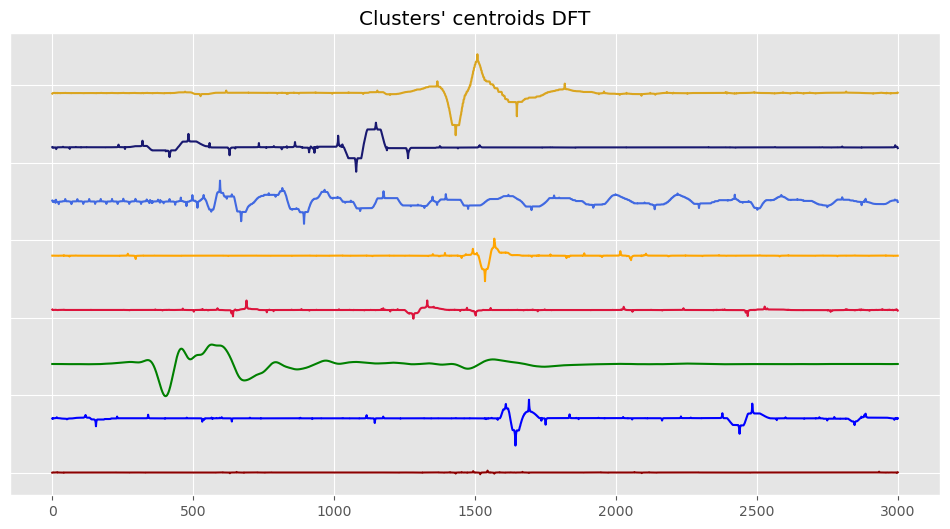

KMeans assigned labels:
 [0 0 0 5 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 1 3 0 3 0 0 0 0 0 0 3 0 0
 6 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 3 0 0 0 0 3 0 0 0 0 2 0 0 3 0 7
 0 0 0 0 0 3 4 0 0 0 0 3 0 0 0 3 0 0 0 0 0 0 0 3 0 4 0 0 0 0 4 4 0 0 0 0 0
 3 0 0 0 0 1 0 0 0 0 0 7 1 0 3 0 0 0 0 0 0 0 3 3 3 0 0 0 0 0 0 4 0 3 0 0 0
 0 0 0 0 3 0 0 0 0 0 3 0 0 3 0 0 0 0 0 0 0 0 0 3 0 0 0 3 0 0 0 0 6 4 0 0 7
 0 0 3 0 0 0 0 0 0 0 3 0 0 0 0 0 0 4 0 0 3 0 0 0 0 0 0 0 4 0 0 0 0 1 0 0 0
 0 0 0 0 0 5 3 0 3 0 3 0 0 3 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 6 0 0 0 0 0 0 0
 0 4 0 0 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 6 0 0 0 0 4 0 0 3 0 0 0 0 0 0
 0 3 0 0 0 0 0 0 0 3 0 0 3 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 6 0 0 3
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 3 0 0 0 0 0 0 0 0 0 3 0]



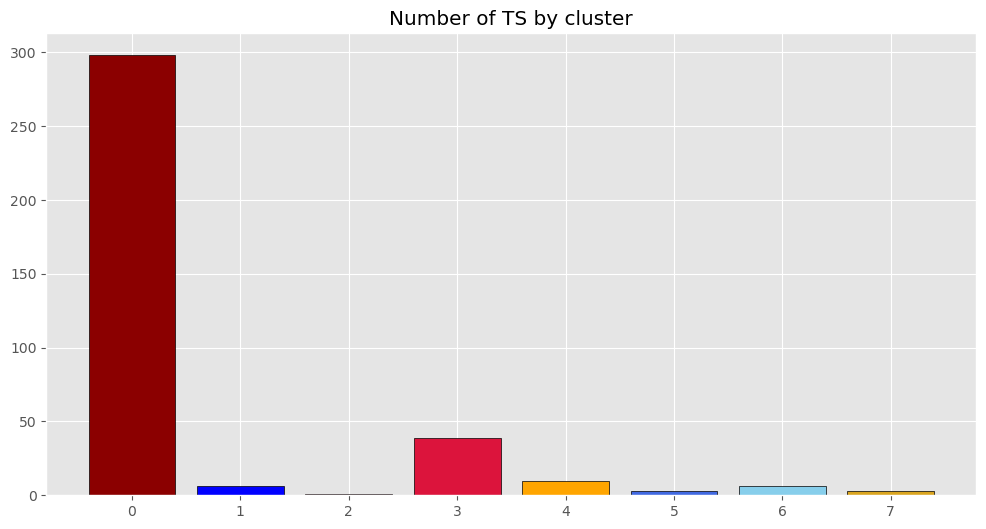


KMeans inertia:  2.764106522663191



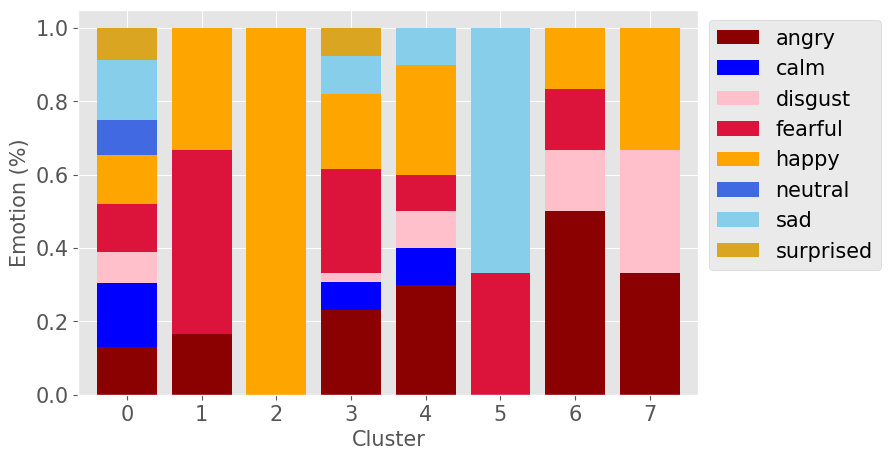



Adjusted_mutual_info_score  = 0.015
Adjusted_rand_score = -0.004
Fowlkes_mallows_score = 0.295
Silhouette_score = 0.632


In [82]:
# inverse transform
df_centroids_dft = np.squeeze(centroids_dft)
colors = ['darkred','blue','green','crimson','orange','royalblue','midnightblue','goldenrod']

# plotting the centroids (disalligned)
for i in range(len(df_centroids_dft)):
#    plt.plot(df_centroids_dft[i], color = colors[i])
#    plt.show()
    c = np.array(df_centroids_dft[i])+ i*7
    plt.plot(c, color = colors[i])
plt.tick_params(left = False, labelleft = False)
plt.title('Clusters\' centroids DFT')
plt.show()

# extracting the labels
km_labels_dft = kmeans_dft.labels_
print('KMeans assigned labels:\n',km_labels_dft)
print()

# n of time series belonging to each cluster
plt.bar(np.unique(km_labels_dft, return_counts=True)[0], np.unique(km_labels_dft, return_counts=True)[1], color = ['darkred','blue','pink','crimson','orange','royalblue','skyblue','goldenrod'], edgecolor = 'k')
plt.title('Number of TS by cluster')
plt.show()
print()

inertia_dft = kmeans_dft.inertia_
print('KMeans inertia: ', inertia_dft)
print()

plot_eval_clust(km_labels_dft, ydf_centr, Xdf_centr_dft)

## Hierarchical Clustering

- For the COMPLETE method, we used as distance DTW
- For the WARD method we could only use EUCLIDEAN metric

In [83]:
Xdf_centr_sax = Xdf_centr_sax.values
Xdf_centr_dft = Xdf_centr_dft.values

### SAX

In [87]:
#d_sax, d_mat_sax = dtw_and_matrix(Xdf_centr_sax)

In [ ]:
#np.save('d_sax.npy', d_sax)
#np.save('d_mat_sax.npy', d_mat_sax)

In [89]:
d_sax = np.load('data_ts\d_sax.npy')
d_mat_sax = np.load('data_ts\d_mat_sax.npy')

### Complete Linkage

Cophenetic Coefficient: 0.9404802635903557


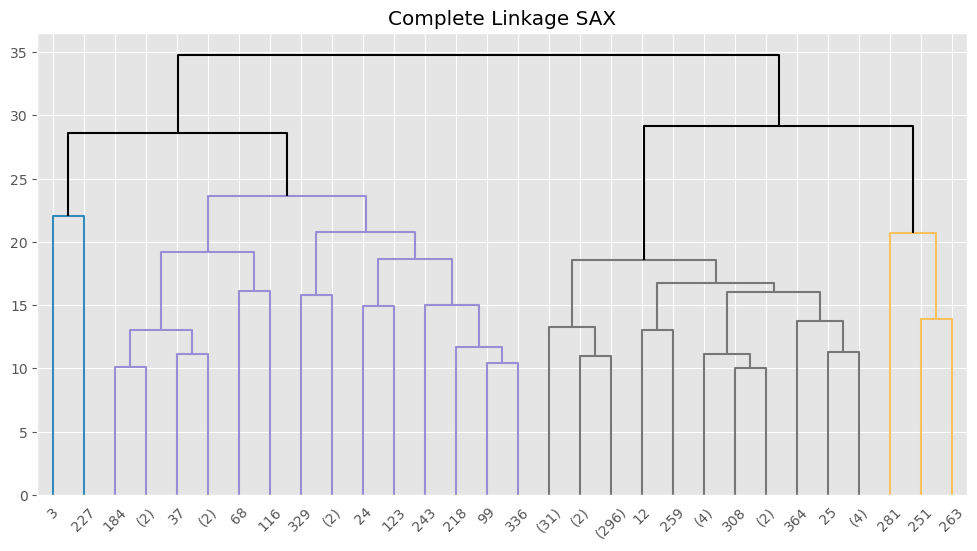

In [90]:
plot_dendr(d_sax,'sax','complete',color_threshold = 25)

### Ward's method

Cophenetic Coefficient: 0.9107444028071852


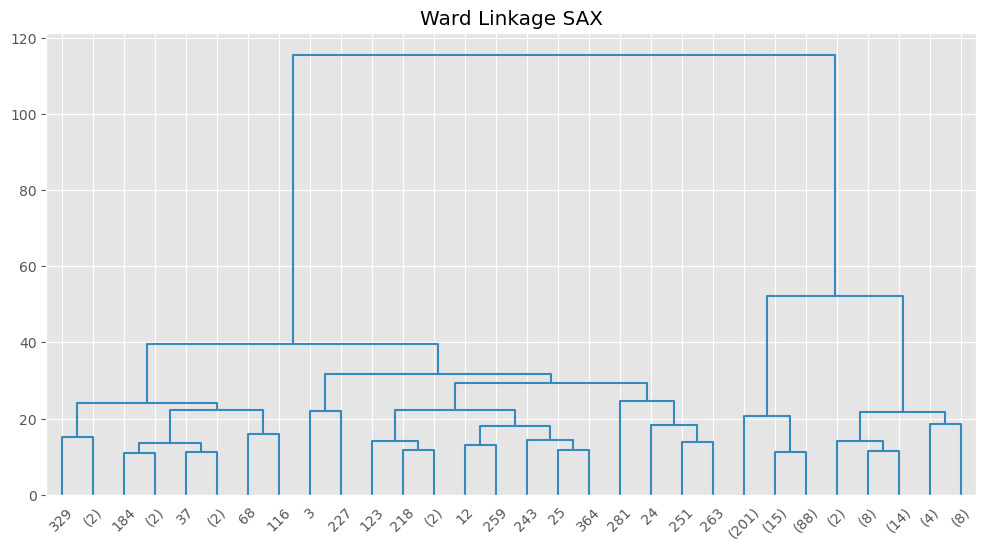

In [91]:
plot_dendr(d_sax,'sax','ward',color_threshold=120)

2    344
0      8
1      6
6      3
4      2
5      1
7      1
3      1
dtype: int64


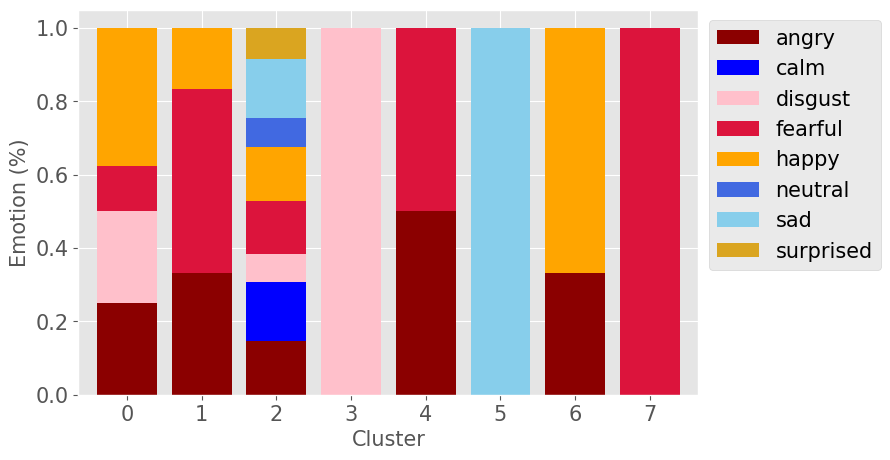



Adjusted_mutual_info_score  = 0.008
Adjusted_rand_score = -0.002
Fowlkes_mallows_score = 0.341
Silhouette_score = 0.633


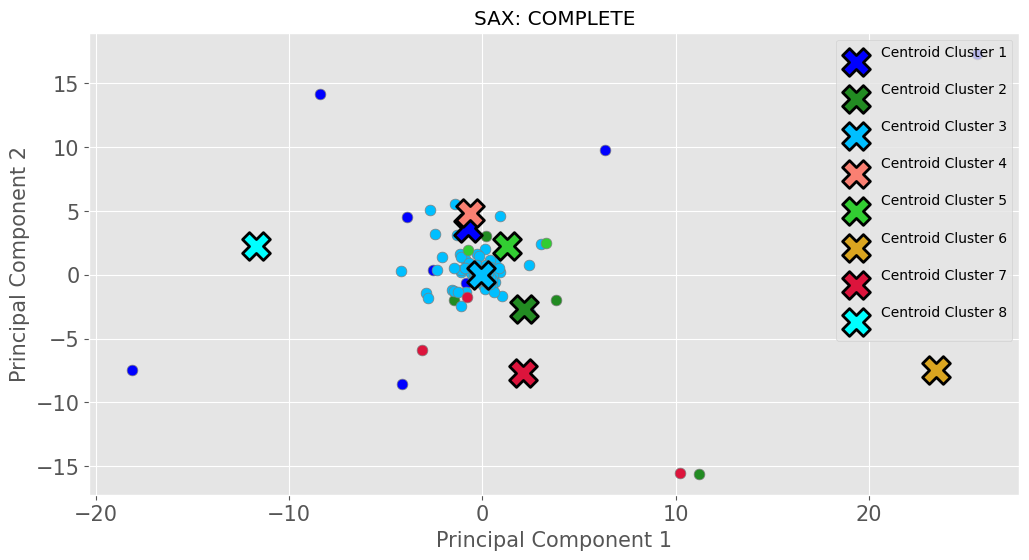

0    353
3      3
2      3
6      2
1      2
5      1
7      1
4      1
dtype: int64


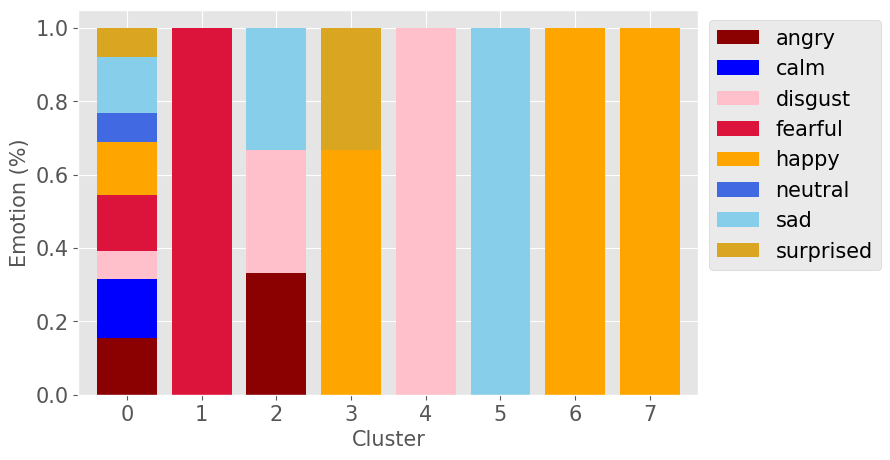



Adjusted_mutual_info_score  = 0.007
Adjusted_rand_score = 0.0
Fowlkes_mallows_score = 0.352
Silhouette_score = 0.636


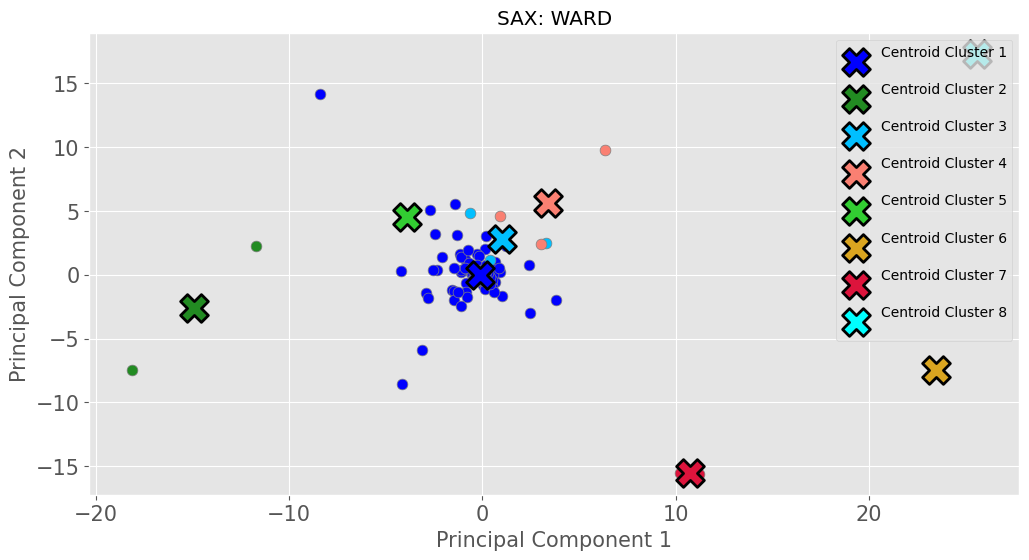

In [92]:
# clustering
data = [d_mat_sax, Xdf_centr_sax]
affinity = ['precomputed','euclidean']
link = ['complete','ward']
for a,l,d in zip(affinity, link, data):
    agg = AgglomerativeClustering(n_clusters = n_clusters, metric = a, linkage = l)
    agg.fit(d)
    labels = agg.labels_
    print(pd.Series(labels).value_counts(), sep = ', ')
    plot_eval_clust(labels, ydf_centr, Xdf_centr_sax)
    plot_pca_clust(Xdf_centr_sax, labels, f'sax: {l}')
#plot_pca_clust(X_clust_sax, y_clust_sax, 'original')

### DFT

In [ ]:
#d_dft, d_mat_dft = dtw_and_matrix(Xdf_centr_dft)

In [ ]:
#np.save('d_dft.npy', d_dft)
#np.save('d_mat_dft.npy', d_mat_dft)

In [93]:
d_dft = np.load('data_ts\d_dft.npy')
d_mat_dft = np.load('data_ts\d_mat_dft.npy')

### Complete Linkage

Cophenetic Coefficient: 0.9517236605493887


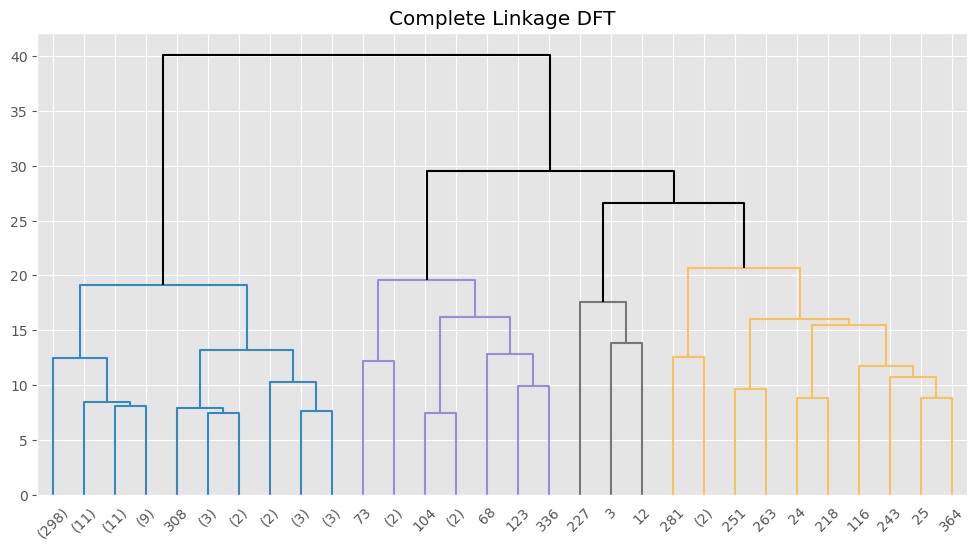

In [ ]:
plot_dendr(d_dft,'dft','complete',color_threshold = 25)

### Ward's method

Cophenetic Coefficient: 0.9262185442983764


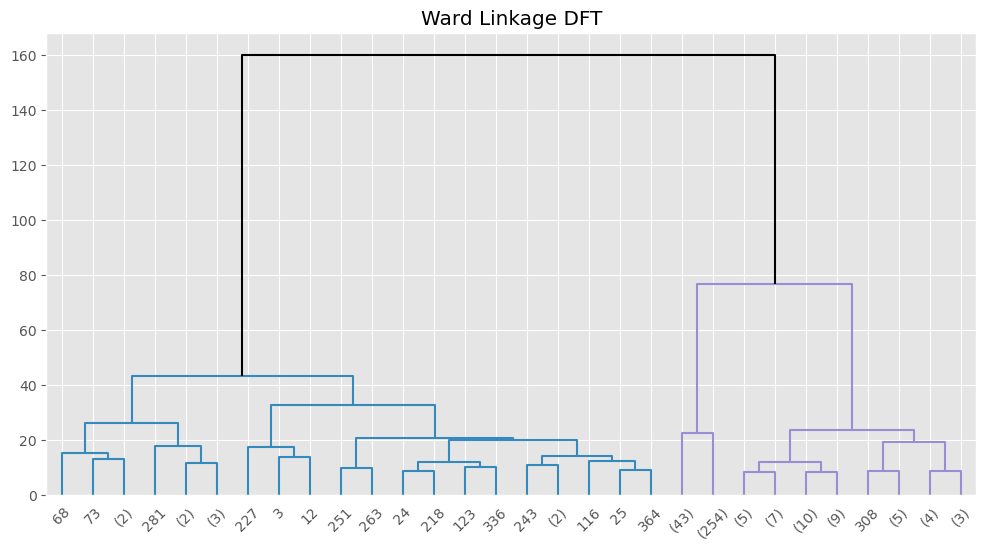

In [ ]:
plot_dendr(d_dft,'dft','ward',color_threshold=120)

6    329
3     14
2      8
0      6
4      3
5      3
1      2
7      1
dtype: int64


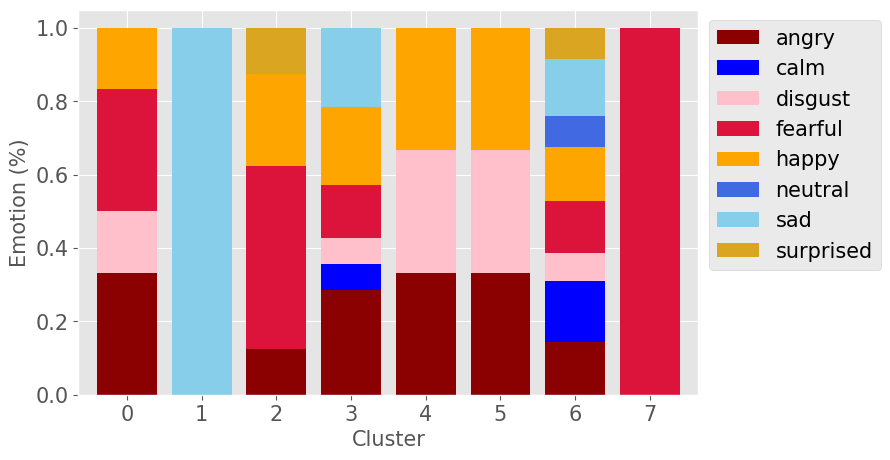



Adjusted_mutual_info_score  = 0.004
Adjusted_rand_score = -0.003
Fowlkes_mallows_score = 0.325
Silhouette_score = 0.527


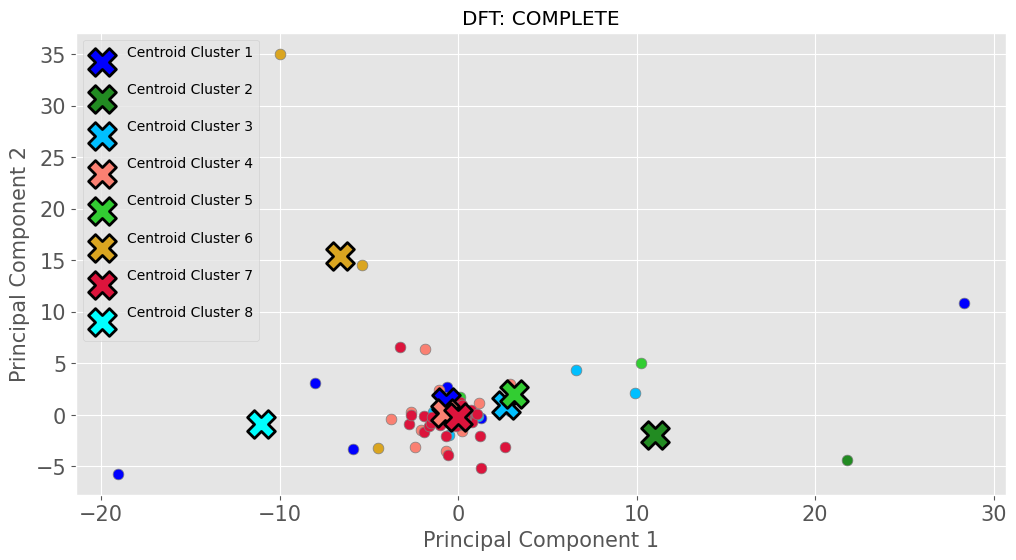

1    354
7      2
2      2
4      2
0      2
3      2
6      1
5      1
dtype: int64


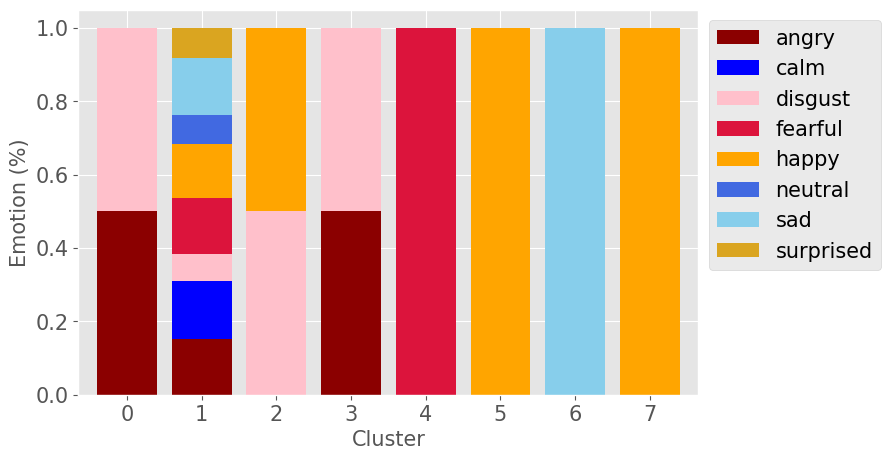



Adjusted_mutual_info_score  = 0.005
Adjusted_rand_score = 0.0
Fowlkes_mallows_score = 0.353
Silhouette_score = 0.702


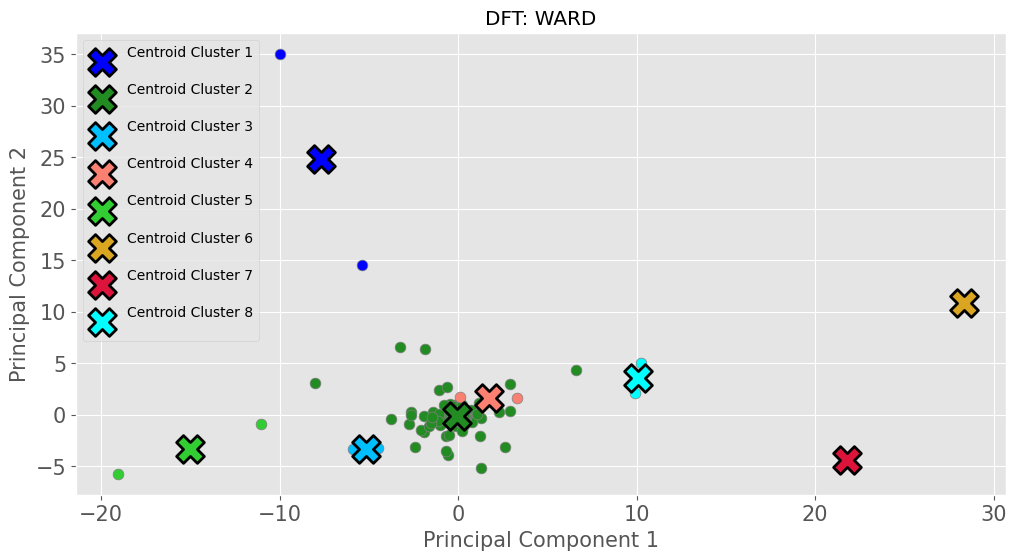

In [ ]:
# clustering
data = [d_mat_dft, Xdf_centr_dft]
affinity = ['precomputed','euclidean']
link = ['complete','ward']
for a,l,d in zip(affinity, link, data):
    agg = AgglomerativeClustering(n_clusters = n_clusters, metric = a, linkage = l)
    agg.fit(d)
    labels = agg.labels_
    print(pd.Series(labels).value_counts(), sep = ', ')
    plot_eval_clust(labels, ydf_centr, Xdf_centr_paa)
    plot_pca_clust(Xdf_centr_paa, labels, f'dft: {l}')
#plot_pca_clust(X_clust_dft, y_clust_dft, 'original')

## Cluster centroids comparison

### KMeans with Euclidean

### KMeans with DTW